[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dgomes03/FIRE-HACK-Project/blob/main/RFR_model.ipynb)

In [100]:
import pandas as pd
import numpy as np
import warnings
import geopandas as gpd
from dbfread import DBF
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import randint, uniform
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
import xgboost as xgb
import shap
import os
import math
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import KFold
from scipy.stats import gaussian_kde

### Load data

In [101]:
print("Loading dataset...")

try:
    shp_path = '../../Data/Processed/PT-FireSprd_v2.1/L2_FireBehavior/PT-FireProg_v2.1_L2_model.shp'
    df = gpd.read_file(shp_path)
    print("Dataset loaded")

except Exception as e:
    print(f"Error loading dataset: {e}")
    raise

Loading dataset...
Dataset loaded


### Remove nans from ros_p

In [102]:
n_before = len(df)
df = df.dropna(subset=['ros_p']).reset_index(drop=True)
n_after = len(df)
print(f"Removed {n_before - n_after} rows with NaN in 'ros_p'. Remaining rows: {n_after}")

Removed 4 rows with NaN in 'ros_p'. Remaining rows: 1173


### Convert categorical variables into "category" type

In [103]:
c = ["fuel_model", "landform", "land_use", "Haines_av"]

for col in c:
     df[col] = df[col].astype(str).astype('category')

### Turn ros lags into log

In [104]:
log_mult = 5
log_base = 10

lags = [col for col in df.columns if col.startswith('ros_p_lg')]

for col in lags:
    log_col = f'{col}_log'
    df[log_col] = np.where(
        df[col] > 0,
        log_mult * np.log1p(df[col]) / np.log(log_base),
        np.nan
    )

df.drop(columns=lags, inplace=True)

### Select specific columns for modeling

In [105]:
c = [
    "duration_p",
    "ros_p_lg1_log",
    "HDW_av",
    "3_8y_fir_p",
    "wv_850_av",
    "rh_950_av",
    "8_ny_fir_p",
    "sW_100_av",
    "f_load_av",
    "wv100_k_av",
    "rh_700_av",
    "CircVar",
    "landform",
    "vwv_500_av",
    "FWI_12h_av",
    "LiftIdx_av",
    "VPD_Pa_av",
    "sW_289_av",
    "DC_12h_av",
    "wv10_kh_av",
    "ros_p"
]

df = df[c]

### Features with highest sum of correlation

In [106]:
num_df = df.select_dtypes(include=["number"])

corr_matrix = num_df.corr()

corr_sum = corr_matrix.abs().sum()

corr_sum = corr_sum.sort_values(ascending=False, kind="mergesort")

print(corr_sum)

"""# change number to change n of top vars to drop
drop = corr_sum.index[:5].tolist()

print("\nVariables removed:")
print(drop)

df = df.drop(columns=drop)"""

wv100_k_av       7.019703
wv10_kh_av       6.405379
sW_100_av        6.261011
HDW_av           6.148039
sW_289_av        5.983929
FWI_12h_av       5.738905
DC_12h_av        5.731694
wv_850_av        5.477652
LiftIdx_av       5.333391
ros_p            5.213699
VPD_Pa_av        4.959274
ros_p_lg1_log    4.784910
rh_950_av        4.526801
duration_p       4.001232
8_ny_fir_p       3.667469
rh_700_av        3.485666
CircVar          3.303803
vwv_500_av       2.877785
3_8y_fir_p       2.795055
f_load_av        2.648215
dtype: float64


'# change number to change n of top vars to drop\ndrop = corr_sum.index[:5].tolist()\n\nprint("\nVariables removed:")\nprint(drop)\n\ndf = df.drop(columns=drop)'

### Create test and train datasets

In [107]:
train_features = [col for col in df.columns if col not in ('ros_p', 'inidoy', 'enddoy', "geometry")]

X = df[train_features]
y = df['ros_p']

### XGBoost Model
This model first uses a KFold approach for Cross-Validation in order to find the best hyperparameters for the XGBoost model. Then, it applies these hyperparameters to train the final model which is trained on 100% of the dataset The "Best Cross-Validation Score (R2)" score given is the average R2 of the Cross Validation process, not the R2 from the final model, since there is not test dataset.

In [108]:
param_dist = {
    'max_depth': [3, 4, 5],                           # ← Reduced from [5, 7, 9, 11, 13, 15]
    'learning_rate': uniform(0.08, 0.22),             # ← Adjusted from (0.01, 0.29)
    'subsample': uniform(0.5, 0.20),                  # ← Reduced from (0.6, 0.4) → 0.5-0.70
    'colsample_bytree': uniform(0.5, 0.20),           # ← Reduced from (0.6, 0.4)
    'colsample_bylevel': uniform(0.5, 0.20),          # ← Reduced from (0.6, 0.4)
    'colsample_bynode': uniform(0.5, 0.20),           # ← Reduced from (0.6, 0.4)
    'min_child_weight': randint(25, 50),              # ← Increased from (1, 10)
    'gamma': uniform(1.5, 2.0),                       # ← Increased from (0, 0.5)
    'reg_alpha': uniform(2, 3),                       # ← Increased from (0, 1)
    'reg_lambda': uniform(6, 4),                      # ← Increased from (1, 3) → 6-10
    'max_delta_step': randint(0, 5),
}


base_model = xgb.XGBRegressor(
    n_jobs=-1, 
    random_state=42,
    objective='reg:squarederror',
    tree_method='hist',
    enable_categorical=True
)


kf = KFold(n_splits=5, shuffle=True, random_state=42)


xgb_random = HalvingRandomSearchCV(
    estimator=base_model,
    param_distributions=param_dist,
    factor=3,
    resource='n_estimators',
    max_resources=200,                                # ← Reduced from 1000
    min_resources=20,                                 # ← Reduced from 100
    scoring='r2',
    cv=kf,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

In [109]:
"""
We apply a log transformation to the target variable 'y' using the formula below.
The parameters can be tweeked if needed. The default is set to a multiplier of 5 and base 10
which give slightly better results.
"""
log_mult = 5
log_base = 10

y_log = log_mult *  np.log1p(y) / np.log(log_base)

xgb_random.fit(
    X, 
    y_log
)

print("\nBest Cross-Validation Score (R2):", xgb_random.best_score_)

final_model = xgb_random.best_estimator_

final_model.save_model("../../Data/Models/XGBoost.json")
print("Trained on full dataset. Best model saved.")

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 20
max_resources_: 200
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 10
n_resources: 20
Fitting 5 folds for each of 10 candidates, totalling 50 fits
----------
iter: 1
n_candidates: 4
n_resources: 60
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 2
n_candidates: 2
n_resources: 180
Fitting 5 folds for each of 2 candidates, totalling 10 fits

Best Cross-Validation Score (R2): 0.6217962069253599
Trained on full dataset. Best model saved.


NOTE: The saved model will make predictions in Log space since it was trained in that space. To see outputs in linear space, a conversion needs to be perfomed after running the model. The code below stores the Log transformation applied so that it can be reversed in the future.

In [110]:
import json
transform_params = {
    'log_mult': log_mult, 
    'log_base': log_base,
    'inverse_formula': 'y_linear = np.exp(y_pred_log * np.log(log_base) / log_mult) - 1'
}
with open('../../Data/Models/XGBoost_transform_param.json', 'w') as f:
    json.dump(transform_params, f)

This file would then be used as follows:
```python
# Load the model
loaded_model = xgb.XGBRegressor()
loaded_model.load_model("../../Data/Models/XGBoost.json")

# Load the transformation parameters
with open('../../Data/Models/XGBoost_transform.json', 'r') as f:
    transform_params = json.load(f)

# Make predictions in log space
y_pred_log = loaded_model.predict(X_new)

# Inverse transform using the saved parameters
log_mult = transform_params['log_mult']
log_base = transform_params['log_base']

y_pred_linear = np.exp(y_pred_log * np.log(log_base) / log_mult) - 1
```

### Debugging code
The code cells below are made for debugging and experimentation. Some of them include residuals anaylsis, SHAP values and better visualizations of model performance.

Total valid samples for Cross-Validation: 1173
--- Processing Fold 1 ---
  Train size: 938
  Test size:  235
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 20
max_resources_: 200
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 10
n_resources: 20
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0]	validation_0-rmse:2.19026
[1]	validation_0-rmse:2.13644
[2]	validation_0-rmse:2.06964
[3]	validation_0-rmse:2.00335
[4]	validation_0-rmse:1.95456
[5]	validation_0-rmse:1.92060
[6]	validation_0-rmse:1.87021
[0]	validation_0-rmse:2.19789
[7]	validation_0-rmse:1.82260
[1]	validation_0-rmse:2.14614
[8]	validation_0-rmse:1.78201
[2]	validation_0-rmse:2.05616
[9]	validation_0-rmse:1.75033
[3]	validation_0-rmse:2.01358
[10]	validation_0-rmse:1.72809
[4]	validation_0-rmse:1.94888
[11]	validation_0-rmse:1.71239
[5]	validation_0-rmse:1.89993
[12]	validation_0-rmse:1.69437
[6]	validation_0-rmse:1.85534
[13]	validation_0-rmse:1.66444

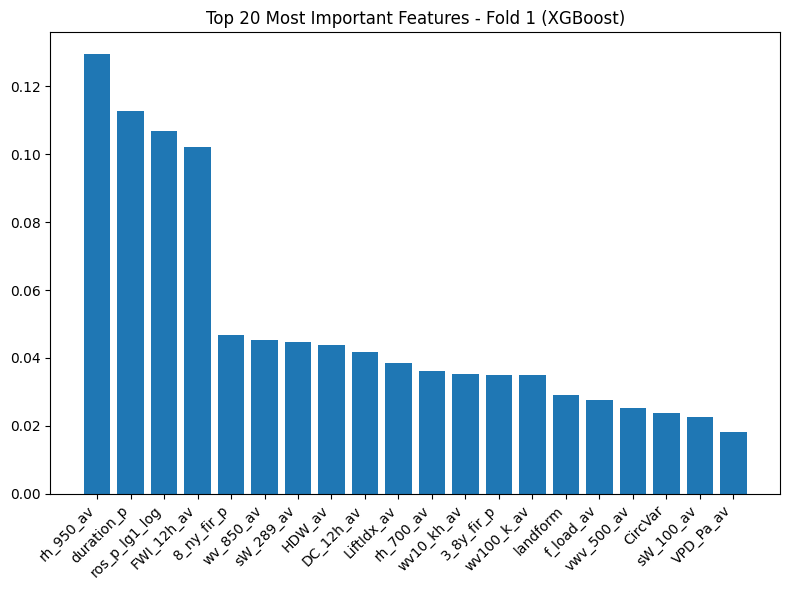


Top 20 Most Important Features:
          feature  importance
5       rh_950_av    0.129356
0      duration_p    0.112735
1   ros_p_lg1_log    0.106816
14     FWI_12h_av    0.102044
6      8_ny_fir_p    0.046888
4       wv_850_av    0.045248
17      sW_289_av    0.044659
2          HDW_av    0.043754
18      DC_12h_av    0.041774
15     LiftIdx_av    0.038508
10      rh_700_av    0.036091
19     wv10_kh_av    0.035200
3      3_8y_fir_p    0.035100
9      wv100_k_av    0.035081
12       landform    0.029205
8       f_load_av    0.027572
13     vwv_500_av    0.025326
11        CircVar    0.023836
7       sW_100_av    0.022632
16      VPD_Pa_av    0.018172


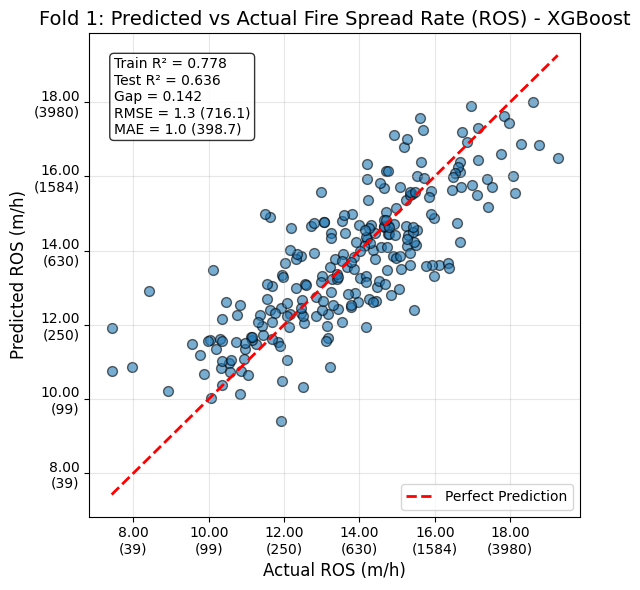

--- Processing Fold 2 ---
  Train size: 938
  Test size:  235
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 20
max_resources_: 200
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 10
n_resources: 20
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0]	validation_0-rmse:2.29425
[1]	validation_0-rmse:2.22657
[2]	validation_0-rmse:2.17046
[3]	validation_0-rmse:2.09701
[4]	validation_0-rmse:2.06092
[5]	validation_0-rmse:2.00793
[6]	validation_0-rmse:1.98316
[7]	validation_0-rmse:1.95452
[8]	validation_0-rmse:1.91227
[9]	validation_0-rmse:1.88661
[10]	validation_0-rmse:1.84864
[11]	validation_0-rmse:1.83369
[12]	validation_0-rmse:1.80404
[13]	validation_0-rmse:1.78107
[14]	validation_0-rmse:1.75408
[15]	validation_0-rmse:1.74530
[16]	validation_0-rmse:1.73181
[0]	validation_0-rmse:2.29136
[17]	validation_0-rmse:1.72446
[1]	validation_0-rmse:2.23051
[18]	validation_0-rmse:1.70679
[0]	validation_0-rmse:2.28888
[2]	validat

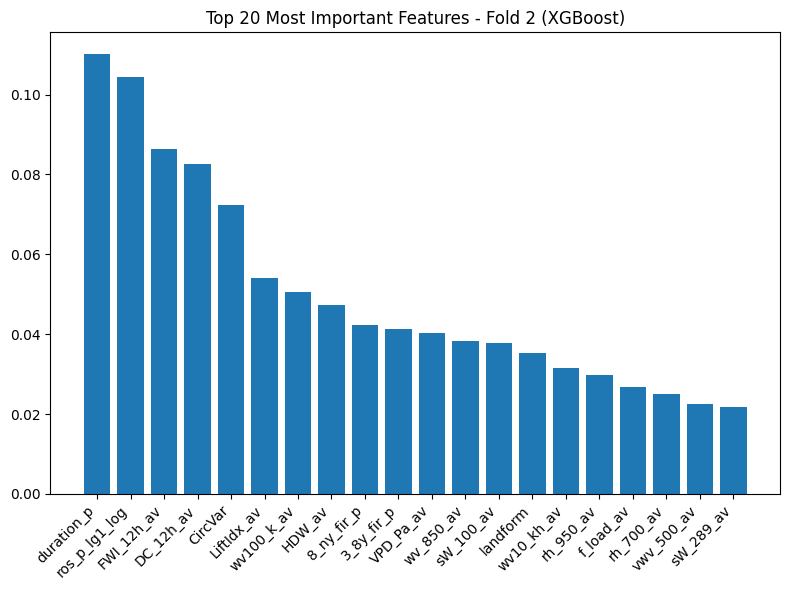


Top 20 Most Important Features:
          feature  importance
0      duration_p    0.110067
1   ros_p_lg1_log    0.104268
14     FWI_12h_av    0.086460
18      DC_12h_av    0.082679
11        CircVar    0.072281
15     LiftIdx_av    0.054084
9      wv100_k_av    0.050440
2          HDW_av    0.047403
6      8_ny_fir_p    0.042270
3      3_8y_fir_p    0.041299
16      VPD_Pa_av    0.040326
4       wv_850_av    0.038231
7       sW_100_av    0.037672
12       landform    0.035359
19     wv10_kh_av    0.031434
5       rh_950_av    0.029655
8       f_load_av    0.026718
10      rh_700_av    0.025078
13     vwv_500_av    0.022601
17      sW_289_av    0.021675


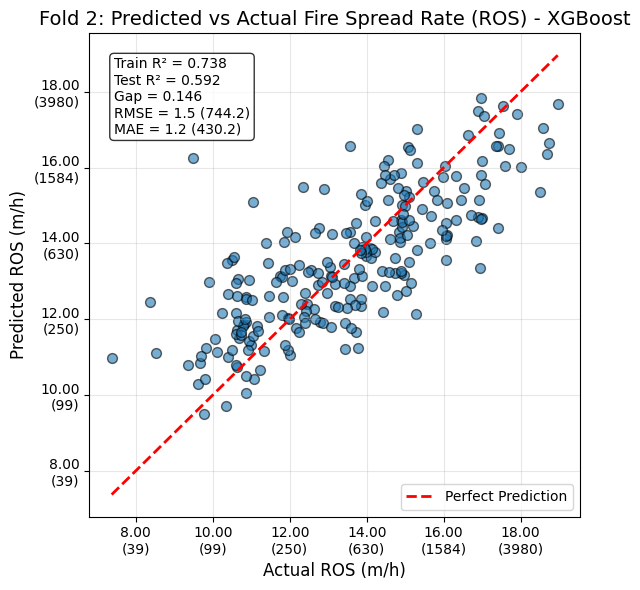

--- Processing Fold 3 ---
  Train size: 938
  Test size:  235
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 20
max_resources_: 200
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 10
n_resources: 20
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0]	validation_0-rmse:2.28125
[1]	validation_0-rmse:2.19386
[2]	validation_0-rmse:2.13229
[3]	validation_0-rmse:2.08322
[4]	validation_0-rmse:2.02768
[5]	validation_0-rmse:1.98659
[6]	validation_0-rmse:1.95400
[7]	validation_0-rmse:1.91116
[8]	validation_0-rmse:1.85898
[9]	validation_0-rmse:1.82965
[10]	validation_0-rmse:1.79509
[0]	validation_0-rmse:2.29484
[11]	validation_0-rmse:1.76268
[12]	validation_0-rmse:1.74132
[1]	validation_0-rmse:2.21488
[13]	validation_0-rmse:1.71007
[14]	validation_0-rmse:1.69568
[2]	validation_0-rmse:2.14364
[15]	validation_0-rmse:1.68328
[3]	validation_0-rmse:2.10555
[4]	validation_0-rmse:2.06064
[5]	validation_0-rmse:1.99795
[16]	validatio

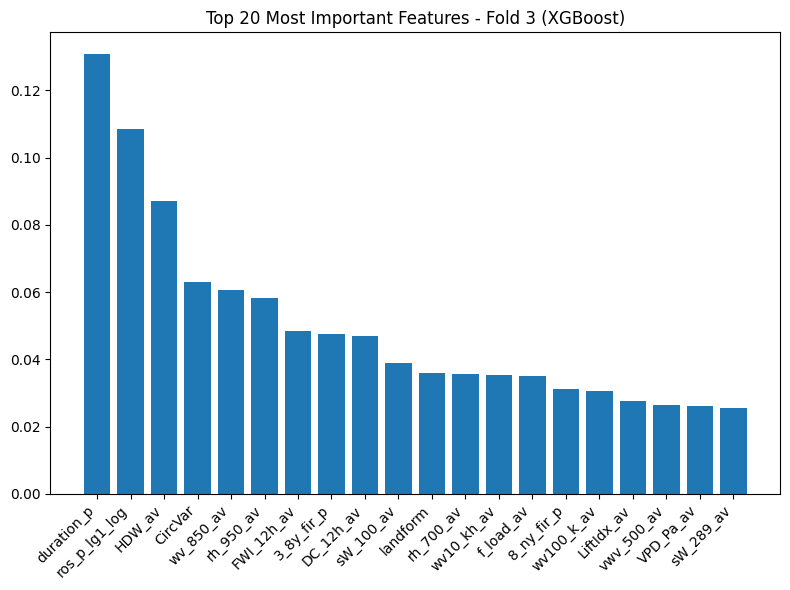


Top 20 Most Important Features:
          feature  importance
0      duration_p    0.130712
1   ros_p_lg1_log    0.108469
2          HDW_av    0.087108
11        CircVar    0.063019
4       wv_850_av    0.060758
5       rh_950_av    0.058315
14     FWI_12h_av    0.048526
3      3_8y_fir_p    0.047439
18      DC_12h_av    0.047026
7       sW_100_av    0.039024
12       landform    0.035845
10      rh_700_av    0.035770
19     wv10_kh_av    0.035247
8       f_load_av    0.035133
6      8_ny_fir_p    0.031050
9      wv100_k_av    0.030584
15     LiftIdx_av    0.027771
13     vwv_500_av    0.026449
16      VPD_Pa_av    0.026189
17      sW_289_av    0.025565


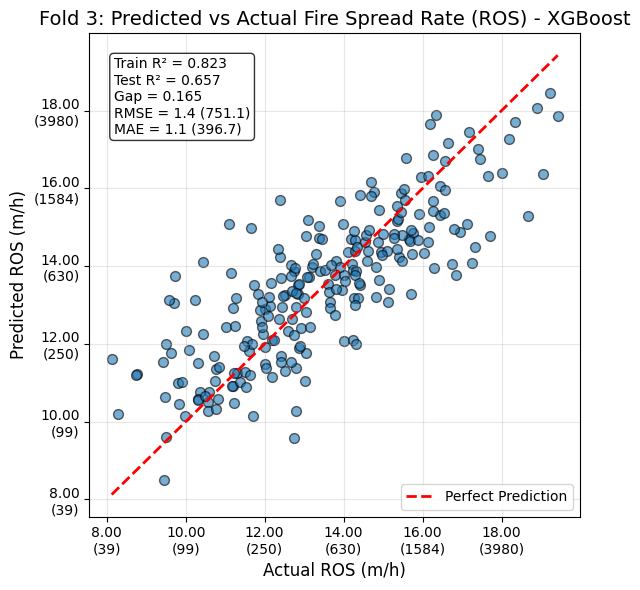

--- Processing Fold 4 ---
  Train size: 939
  Test size:  234
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 20
max_resources_: 200
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 10
n_resources: 20
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0]	validation_0-rmse:2.43403
[1]	validation_0-rmse:2.38328
[2]	validation_0-rmse:2.30947
[3]	validation_0-rmse:2.24170
[4]	validation_0-rmse:2.19748
[5]	validation_0-rmse:2.16381
[6]	validation_0-rmse:2.11840
[7]	validation_0-rmse:2.09904
[8]	validation_0-rmse:2.03976
[9]	validation_0-rmse:2.00909
[10]	validation_0-rmse:1.97722
[11]	validation_0-rmse:1.94831
[12]	validation_0-rmse:1.91146
[13]	validation_0-rmse:1.86786
[14]	validation_0-rmse:1.84843
[15]	validation_0-rmse:1.83030
[16]	validation_0-rmse:1.81541
[17]	validation_0-rmse:1.79024
[18]	validation_0-rmse:1.76462
[19]	validation_0-rmse:1.75338
[0]	validation_0-rmse:2.42579
[1]	validation_0-rmse:2.36723
[2]	valida

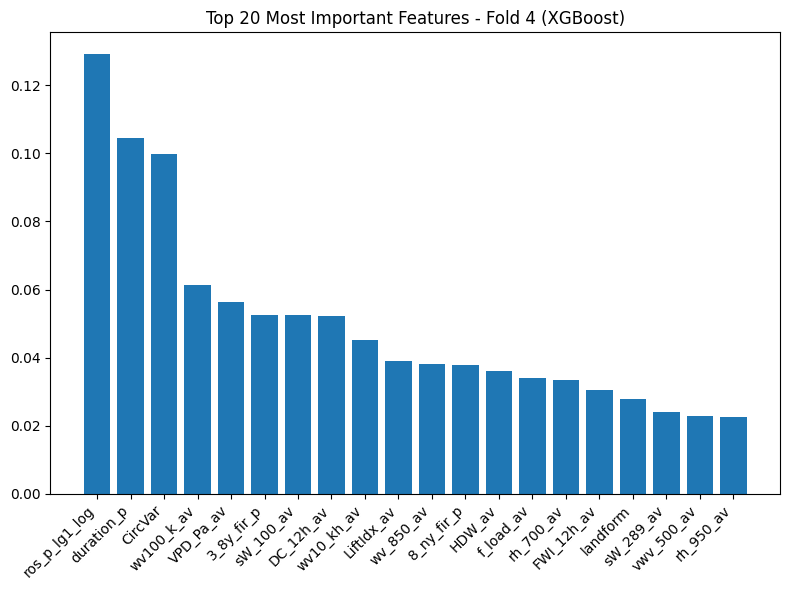


Top 20 Most Important Features:
          feature  importance
1   ros_p_lg1_log    0.129050
0      duration_p    0.104423
11        CircVar    0.099653
9      wv100_k_av    0.061205
16      VPD_Pa_av    0.056412
3      3_8y_fir_p    0.052501
7       sW_100_av    0.052472
18      DC_12h_av    0.052245
19     wv10_kh_av    0.045188
15     LiftIdx_av    0.039018
4       wv_850_av    0.038205
6      8_ny_fir_p    0.037814
2          HDW_av    0.036074
8       f_load_av    0.034125
10      rh_700_av    0.033453
14     FWI_12h_av    0.030612
12       landform    0.027779
17      sW_289_av    0.024190
13     vwv_500_av    0.022861
5       rh_950_av    0.022718


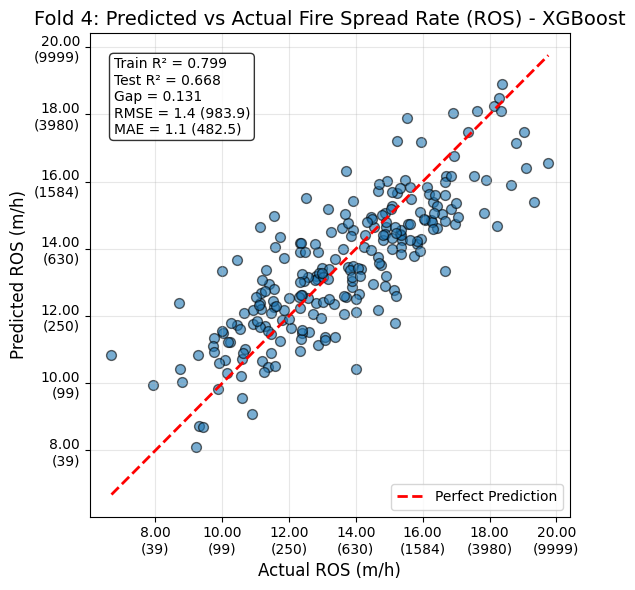

--- Processing Fold 5 ---
  Train size: 939
  Test size:  234
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 20
max_resources_: 200
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 10
n_resources: 20
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0]	validation_0-rmse:2.40619
[1]	validation_0-rmse:2.32833
[2]	validation_0-rmse:2.27058
[3]	validation_0-rmse:2.20337
[4]	validation_0-rmse:2.14307
[5]	validation_0-rmse:2.11156
[0]	validation_0-rmse:2.39817
[6]	validation_0-rmse:2.07445
[1]	validation_0-rmse:2.34608
[7]	validation_0-rmse:2.05162
[8]	validation_0-rmse:2.01185
[2]	validation_0-rmse:2.26086
[3]	validation_0-rmse:2.23375
[9]	validation_0-rmse:1.98966
[0]	validation_0-rmse:2.38397
[4]	validation_0-rmse:2.20789
[1]	validation_0-rmse:2.34210
[10]	validation_0-rmse:1.96943
[5]	validation_0-rmse:2.17769
[2]	validation_0-rmse:2.28872
[11]	validation_0-rmse:1.94576
[6]	validation_0-rmse:2.14611
[3]	validation_0-r

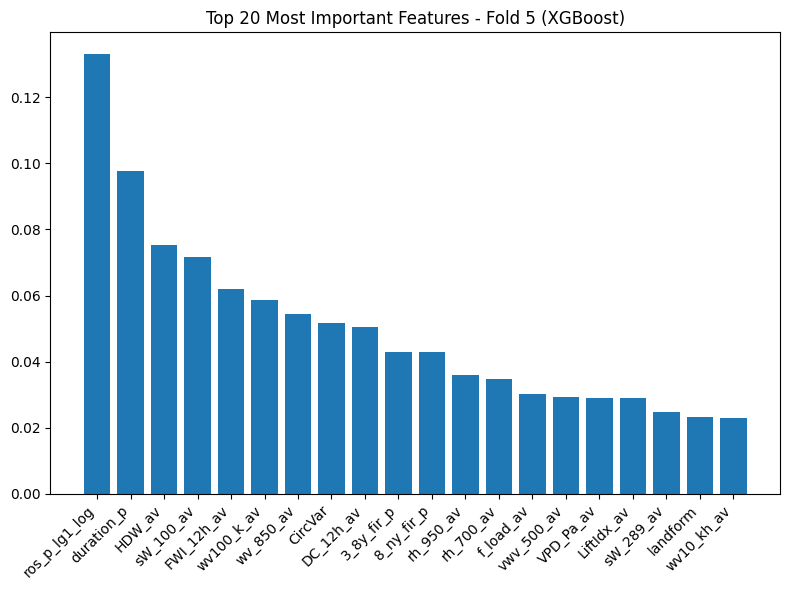


Top 20 Most Important Features:
          feature  importance
1   ros_p_lg1_log    0.132973
0      duration_p    0.097705
2          HDW_av    0.075183
7       sW_100_av    0.071601
14     FWI_12h_av    0.062050
9      wv100_k_av    0.058624
4       wv_850_av    0.054308
11        CircVar    0.051655
18      DC_12h_av    0.050560
3      3_8y_fir_p    0.043056
6      8_ny_fir_p    0.042791
5       rh_950_av    0.035974
10      rh_700_av    0.034827
8       f_load_av    0.030115
13     vwv_500_av    0.029320
16      VPD_Pa_av    0.029144
15     LiftIdx_av    0.029068
17      sW_289_av    0.024662
12       landform    0.023277
19     wv10_kh_av    0.023107


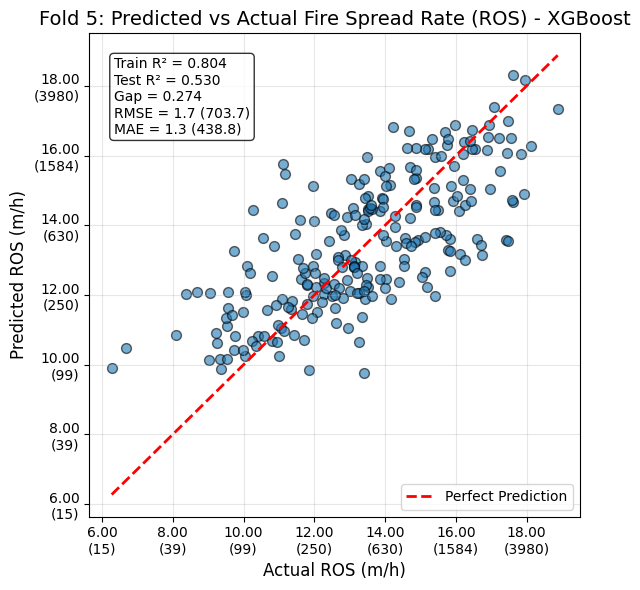


FINAL CROSS-VALIDATION RESULTS (AVERAGED ACROSS ALL FOLDS)

Per-Fold Metrics:
 fold  train_r2  test_r2  overfitting_gap  rmse_log  mae_log  rmse_linear  mae_linear  n_estimators  max_depth
    1  0.778088 0.636446         0.141642  1.343468 1.037653   716.121995  398.690768           180          4
    2  0.738129 0.592167         0.145962  1.494780 1.170062   744.226693  430.213896           180          3
    3  0.822599 0.657269         0.165330  1.370891 1.053396   751.107059  396.650549           180          4
    4  0.798812 0.667561         0.131251  1.429315 1.146602   983.864651  482.516550           180          3
    5  0.804022 0.529704         0.274318  1.659601 1.312122   703.710777  438.780635           180          4

------------------------------------------------------------
AVERAGE METRICS:
------------------------------------------------------------
Train R² (log):        0.7883 ± 0.0322
Test R² (log):         0.6166 ± 0.0566
Overfitting Gap:       0.1717 ± 0.058

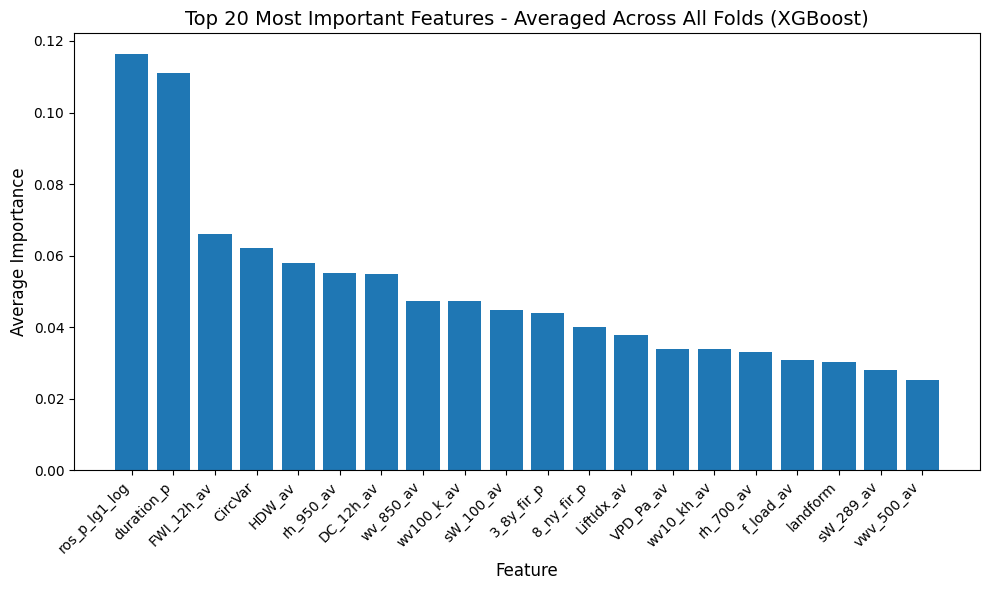


------------------------------------------------------------
OVERALL METRICS (ALL PREDICTIONS COMBINED):
------------------------------------------------------------
Train R² (log):        0.7882
Test R² (log):         0.6171
Overfitting Gap:       0.1711
RMSE (log):            1.4638
MAE (log):             1.1438
RMSE (linear):         786.5
MAE (linear):          429.3


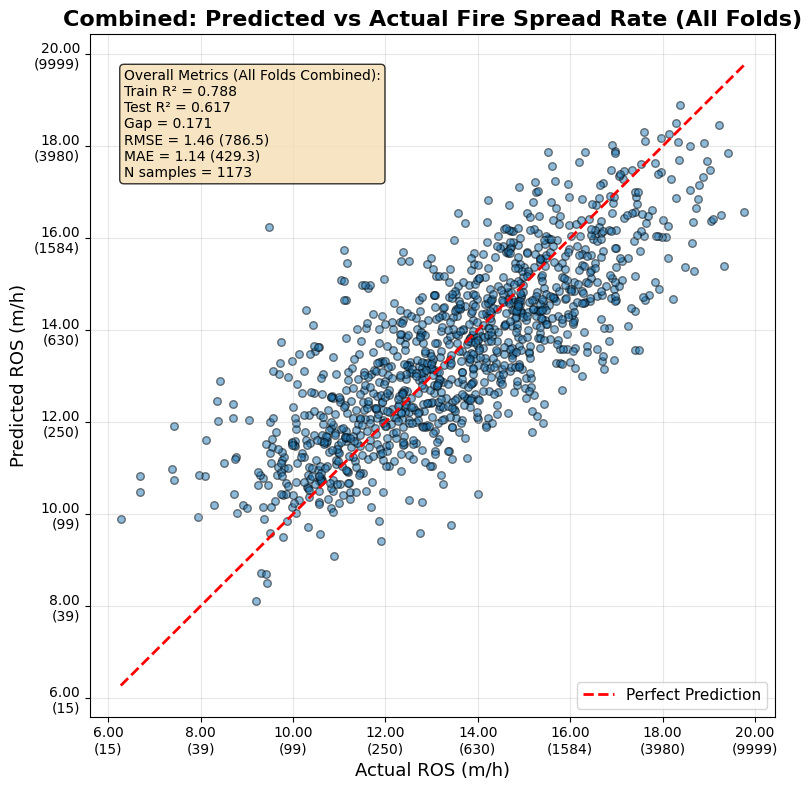


CROSS-VALIDATION COMPLETE


In [111]:
"""
este codigo faz mais ou menos o que esta acima mas 
manualmente e com mais outputs intermediarios. 
a diferença é que nao treino o modelo no dataset inteiro.
Sao feitos 5 folds, e no final feito uma media dos resultados e
graficos com todos os pontos juntos.
No codigo acima, também sao feitos os 5 folds, mas apenas para
descobrir os melhores hiperparametros. Depois o modelo é treinado
no dataset inteiro com esses hiperparametros.
"""

param_dist = {
    'max_depth': [3, 4, 5],                           # ← Add 4 back for flexibility
    'learning_rate': uniform(0.08, 0.22),             # ← Narrow to 0.08-0.30
    'subsample': uniform(0.5, 0.20),                  # ← 0.5-0.70 (even more aggressive)
    'colsample_bytree': uniform(0.5, 0.20),           
    'colsample_bylevel': uniform(0.5, 0.20),          
    'colsample_bynode': uniform(0.5, 0.20),           
    'min_child_weight': randint(25, 50),              # ← Tighter range 25-50
    'gamma': uniform(1.5, 2.0),                       # ← 1.5-3.5 (stronger pruning)
    'reg_alpha': uniform(2, 3),                       # ← 2-5
    'reg_lambda': uniform(6, 4),                      # ← 6-10
    'max_delta_step': randint(0, 5),
}

# XGBoost model with early stopping
base_model = xgb.XGBRegressor(
    n_jobs=-1, 
    random_state=42,
    objective='reg:squarederror',
    tree_method='hist',                               # faster histogram-based algorithm
    early_stopping_rounds=50,                         # stop if no improvement
    enable_categorical=True                           # handle categorical features better
)


kf = KFold(n_splits=5, shuffle=True, random_state=42)

xgb_random = HalvingRandomSearchCV(
    estimator=base_model,
    param_distributions=param_dist,
    factor=3,
    resource='n_estimators',
    max_resources=200,                                # ← Further reduced from 300
    min_resources=20,                                 # ← Reduced from 30
    scoring='r2',
    cv=kf,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

train_features = [col for col in df.columns if col not in ('ros_p', 'inidoy', 'enddoy', "geometry")]

X = df[train_features].copy()
y = df['ros_p'].copy()

valid_mask = y != -1
X = X[valid_mask].reset_index(drop=True)
y = y[valid_mask].reset_index(drop=True)

print(f"Total valid samples for Cross-Validation: {len(X)}")

# TRACKING FOR AVERAGED RESULTS
fold_metrics = []
all_y_test_log = []
all_y_pred_log = []
all_y_test_linear = []
all_y_pred_linear = []
all_y_train_log = []                                  # ← Added for train predictions
all_y_train_pred_log = []                             # ← Added for train predictions
all_feature_importances = []

# CROSS-VALIDATION LOOP
fold = 1
for train_index, test_index in kf.split(X, y):
    print(f"--- Processing Fold {fold} ---")
    
    # Split the data based on the current fold's indices
    X_train_final, X_test_final = X.iloc[train_index], X.iloc[test_index]
    y_train_final, y_test_final = y.iloc[train_index], y.iloc[test_index]

    log_mult = 5 
    log_base = 10

    y_train_log = log_mult *  np.log1p(y_train_final) / np.log(log_base)
    y_test_log = log_mult * np.log1p(y_test_final) / np.log(log_base)

    
    print(f"  Train size: {len(X_train_final)}")
    print(f"  Test size:  {len(X_test_final)}")
    
    # Train the model
    xgb_random.fit(
        X_train_final, 
        y_train_log,
        eval_set=[(X_test_final, y_test_log)]         # ← Changed from train to test for early stopping
    )

    # Get the best model and parameters
    print(f"\nSearch complete.")
    print(f"Best parameters found: {xgb_random.best_params_}")
    best_model = xgb_random.best_estimator_

    # Make predictions with the best model - TRAIN SET
    y_train_pred_log = best_model.predict(X_train_final)  # ← Added
    
    # Make predictions with the best model - TEST SET
    y_pred_log = best_model.predict(X_test_final)

    # Inverse transform log to linear
    inv_mult = np.log(log_base) / log_mult
    y_test_linear = np.exp(y_test_log * inv_mult) - 1
    y_pred_linear = np.exp(y_pred_log * inv_mult) - 1

    # Metrics in log space - TEST
    r2_test = r2_score(y_test_log, y_pred_log)
    rmse_log = np.sqrt(mean_squared_error(y_test_log, y_pred_log))
    mae_log = mean_absolute_error(y_test_log, y_pred_log)

    # Metrics in log space - TRAIN (for overfitting check)
    r2_train = r2_score(y_train_log, y_train_pred_log)    # ← Added

    # Metrics in linear space
    rmse_linear = np.sqrt(mean_squared_error(y_test_linear, y_pred_linear))
    mae_linear = mean_absolute_error(y_test_linear, y_pred_linear)

    # Store metrics for averaging
    fold_metrics.append({
        'fold': fold,
        'train_r2': r2_train,                          # ← Added
        'test_r2': r2_test,                            # ← Renamed from 'r2'
        'overfitting_gap': r2_train - r2_test,         # ← Added
        'rmse_log': rmse_log,
        'mae_log': mae_log,
        'rmse_linear': rmse_linear,
        'mae_linear': mae_linear,
        'n_estimators': best_model.n_estimators,
        'max_depth': best_model.max_depth
    })

    # Store predictions for combined plot
    all_y_test_log.extend(y_test_log.tolist())
    all_y_pred_log.extend(y_pred_log.tolist())
    all_y_test_linear.extend(y_test_linear.tolist())
    all_y_pred_linear.extend(y_pred_linear.tolist())
    all_y_train_log.extend(y_train_log.tolist())          # ← Added
    all_y_train_pred_log.extend(y_train_pred_log.tolist()) # ← Added

    # Feature importance
    feature_names = X_train_final.columns.tolist()
    importances = pd.DataFrame({
        'feature': feature_names,
        'importance': best_model.feature_importances_
    })
    importances = importances.sort_values('importance', ascending=False)
    all_feature_importances.append(importances)

    print("\nLog scale metrics:")
    print(f"Train R² (log): {r2_train:.4f}")            # ← Added
    print(f"Test R² (log):  {r2_test:.4f}")             # ← Added
    print(f"Overfitting Gap: {r2_train - r2_test:.4f}") # ← Added
    print(f"RMSE (log): {rmse_log:.4f} (linear: {rmse_linear:.1f})")
    print(f"MAE (log): {mae_log:.4f} (linear: {mae_linear:.1f})")
    print(f"\nBest n_estimators: {best_model.n_estimators}")
    print(f"Best max_depth: {best_model.max_depth}")

    # Plot feature importance
    plt.figure(figsize=(8, 6))
    plt.bar(importances['feature'][:20], importances['importance'][:20])
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Top 20 Most Important Features - Fold {fold} (XGBoost)')
    plt.tight_layout()
    plt.show()

    print("\nTop 20 Most Important Features:")
    print(importances.head(20))

    # Predicted vs Actual scatter plot
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test_log, y_pred_log, alpha=0.6, edgecolor='k', s=50)

    # Perfect prediction line
    min_val = min(y_test_log.min(), y_pred_log.min())
    max_val = max(y_test_log.max(), y_pred_log.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

    plt.title(f'Fold {fold}: Predicted vs Actual Fire Spread Rate (ROS) - XGBoost', fontsize=14)
    plt.xlabel('Actual ROS (m/h)', fontsize=12)
    plt.ylabel('Predicted ROS (m/h)', fontsize=12)

    # Add metrics annotation with both log and linear scales
    plt.text(0.05, 0.95, 
        f'Train R² = {r2_train:.3f}\n'                 # ← Added
        f'Test R² = {r2_test:.3f}\n'                   # ← Modified
        f'Gap = {r2_train - r2_test:.3f}\n'            # ← Added
        f'RMSE = {rmse_log:.1f} ({rmse_linear:.1f})\n'
        f'MAE = {mae_log:.1f} ({mae_linear:.1f})', 
        transform=plt.gca().transAxes, 
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # inverse-transform scaling factor
    inv_mult = np.log(log_base) / log_mult

    def tick_formatter_log_to_linear(x, pos):
        """Formats tick: log_value  (linear_value)"""
        linear_val = np.exp(x * inv_mult) - 1
        return f"{x:.2f}\n({linear_val:.0f})"

    ax = plt.gca()
    ax.xaxis.set_major_formatter(plt.FuncFormatter(tick_formatter_log_to_linear))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(tick_formatter_log_to_linear))

    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    
    fold += 1


# AVERAGED RESULTS

print("\n" + "="*60)
print("FINAL CROSS-VALIDATION RESULTS (AVERAGED ACROSS ALL FOLDS)")
print("="*60)

# Create metrics dataframe
metrics_df = pd.DataFrame(fold_metrics)
print("\nPer-Fold Metrics:")
print(metrics_df.to_string(index=False))

# Calculate averages
avg_metrics = metrics_df.mean(numeric_only=True)
std_metrics = metrics_df.std(numeric_only=True)

print("\n" + "-"*60)
print("AVERAGE METRICS:")
print("-"*60)
print(f"Train R² (log):        {avg_metrics['train_r2']:.4f} ± {std_metrics['train_r2']:.4f}")  # ← Added
print(f"Test R² (log):         {avg_metrics['test_r2']:.4f} ± {std_metrics['test_r2']:.4f}")   # ← Modified
print(f"Overfitting Gap:       {avg_metrics['overfitting_gap']:.4f} ± {std_metrics['overfitting_gap']:.4f}")  # ← Added
print(f"RMSE (log):            {avg_metrics['rmse_log']:.4f} ± {std_metrics['rmse_log']:.4f}")
print(f"MAE (log):             {avg_metrics['mae_log']:.4f} ± {std_metrics['mae_log']:.4f}")
print(f"RMSE (linear):         {avg_metrics['rmse_linear']:.1f} ± {std_metrics['rmse_linear']:.1f}")
print(f"MAE (linear):          {avg_metrics['mae_linear']:.1f} ± {std_metrics['mae_linear']:.1f}")
print(f"Avg n_estimators:      {avg_metrics['n_estimators']:.1f}")
print(f"Avg max_depth:         {avg_metrics['max_depth']:.1f}")

# Average feature importances across all folds
avg_feature_importance = pd.concat(all_feature_importances).groupby('feature')['importance'].mean()
avg_feature_importance = avg_feature_importance.sort_values(ascending=False).reset_index()
avg_feature_importance.columns = ['feature', 'importance']

print("\n" + "-"*60)
print("TOP 20 MOST IMPORTANT FEATURES (AVERAGED):")
print("-"*60)
print(avg_feature_importance.head(20).to_string(index=False))

# Plot averaged feature importance
plt.figure(figsize=(10, 6))
plt.bar(avg_feature_importance['feature'][:20], avg_feature_importance['importance'][:20])
plt.xticks(rotation=45, ha='right')
plt.title('Top 20 Most Important Features - Averaged Across All Folds (XGBoost)', fontsize=14)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Average Importance', fontsize=12)
plt.tight_layout()
plt.show()

# Convert to numpy arrays for overall metrics
all_y_test_log = np.array(all_y_test_log)
all_y_pred_log = np.array(all_y_pred_log)
all_y_test_linear = np.array(all_y_test_linear)
all_y_pred_linear = np.array(all_y_pred_linear)
all_y_train_log = np.array(all_y_train_log)                # ← Added
all_y_train_pred_log = np.array(all_y_train_pred_log)      # ← Added

# Calculate overall metrics on all predictions combined
overall_r2_test = r2_score(all_y_test_log, all_y_pred_log)
overall_r2_train = r2_score(all_y_train_log, all_y_train_pred_log)  # ← Added
overall_rmse_log = np.sqrt(mean_squared_error(all_y_test_log, all_y_pred_log))
overall_mae_log = mean_absolute_error(all_y_test_log, all_y_pred_log)
overall_rmse_linear = np.sqrt(mean_squared_error(all_y_test_linear, all_y_pred_linear))
overall_mae_linear = mean_absolute_error(all_y_test_linear, all_y_pred_linear)

print("\n" + "-"*60)
print("OVERALL METRICS (ALL PREDICTIONS COMBINED):")
print("-"*60)
print(f"Train R² (log):        {overall_r2_train:.4f}")     # ← Added
print(f"Test R² (log):         {overall_r2_test:.4f}")      # ← Modified
print(f"Overfitting Gap:       {overall_r2_train - overall_r2_test:.4f}")  # ← Added
print(f"RMSE (log):            {overall_rmse_log:.4f}")
print(f"MAE (log):             {overall_mae_log:.4f}")
print(f"RMSE (linear):         {overall_rmse_linear:.1f}")
print(f"MAE (linear):          {overall_mae_linear:.1f}")

# Final combined scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(all_y_test_log, all_y_pred_log, alpha=0.5, edgecolor='k', s=30)

# Perfect prediction line
min_val = min(all_y_test_log.min(), all_y_pred_log.min())
max_val = max(all_y_test_log.max(), all_y_pred_log.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

plt.title('Combined: Predicted vs Actual Fire Spread Rate (All Folds)', fontsize=16, fontweight='bold')
plt.xlabel('Actual ROS (m/h)', fontsize=13)
plt.ylabel('Predicted ROS (m/h)', fontsize=13)

# Add metrics annotation
metrics_text = (
    f'Overall Metrics (All Folds Combined):\n'
    f'Train R² = {overall_r2_train:.3f}\n'             # ← Added
    f'Test R² = {overall_r2_test:.3f}\n'               # ← Modified
    f'Gap = {overall_r2_train - overall_r2_test:.3f}\n'  # ← Added
    f'RMSE = {overall_rmse_log:.2f} ({overall_rmse_linear:.1f})\n'
    f'MAE = {overall_mae_log:.2f} ({overall_mae_linear:.1f})\n'
    f'N samples = {len(all_y_test_log)}'
)
plt.text(0.05, 0.95, 
    metrics_text, 
    transform=plt.gca().transAxes, 
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
    fontsize=10)

# inverse-transform scaling factor
inv_mult = np.log(log_base) / log_mult

def tick_formatter_log_to_linear(x, pos):
    """Formats tick: log_value  (linear_value)"""
    linear_val = np.exp(x * inv_mult) - 1
    return f"{x:.2f}\n({linear_val:.0f})"

ax = plt.gca()
ax.xaxis.set_major_formatter(plt.FuncFormatter(tick_formatter_log_to_linear))
ax.yaxis.set_major_formatter(plt.FuncFormatter(tick_formatter_log_to_linear))

plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("CROSS-VALIDATION COMPLETE")
print("="*60)

NOTE: The slight difference in R2 between the Final model and this debug code is expected and comes from several factors like using 5 independent test sets to calculate the mean R2, unlike the Final model which doesn't have test sets, and differences in random_states.

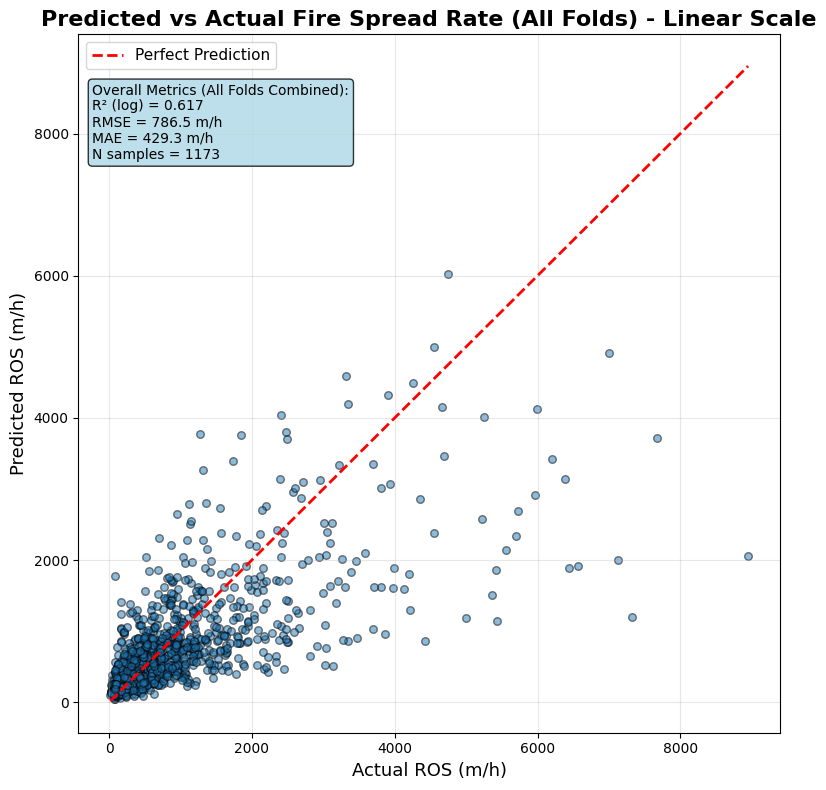

In [112]:
"""
The same plot as above but in linear scale
"""
plt.figure(figsize=(8, 8))
plt.scatter(all_y_test_linear, all_y_pred_linear, alpha=0.5, edgecolor='k', s=30)

min_val_linear = min(all_y_test_linear.min(), all_y_pred_linear.min())
max_val_linear = max(all_y_test_linear.max(), all_y_pred_linear.max())
plt.plot([min_val_linear, max_val_linear], [min_val_linear, max_val_linear], 'r--', linewidth=2, label='Perfect Prediction')

plt.title('Predicted vs Actual Fire Spread Rate (All Folds) - Linear Scale', fontsize=16, fontweight='bold')
plt.xlabel('Actual ROS (m/h)', fontsize=13)
plt.ylabel('Predicted ROS (m/h)', fontsize=13)

metrics_text = (
    f'Overall Metrics (All Folds Combined):\n'
    f'R² (log) = {overall_r2_test:.3f}\n'
    f'RMSE = {overall_rmse_linear:.1f} m/h\n'
    f'MAE = {overall_mae_linear:.1f} m/h\n'
    f'N samples = {len(all_y_test_linear)}'
)
plt.text(0.02, 0.93, 
    metrics_text, 
    transform=plt.gca().transAxes, 
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8),
    fontsize=10)

plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Residuals analysis in log and linear scales


RESIDUAL ANALYSIS

RESIDUAL STATISTICS (Log Scale):
Mean Residual:        -0.0074
Median Residual:      0.0081
Std Dev Residual:     1.4638
Min Residual:         -6.7633
Max Residual:         3.9282

RESIDUAL STATISTICS (Linear Scale):
Mean Residual:        153.95 m/h
Median Residual:      1.69 m/h
Std Dev Residual:     771.31 m/h
Min Residual:         -2496.76 m/h
Max Residual:         6899.02 m/h

Predictions within ±0.5 (log):   28.4%
Predictions within ±1.0 (log):   51.6%
Predictions within ±2.0 (log):   84.5%

Predictions within ±10 m/h:   3.7%
Predictions within ±50 m/h:   17.6%
Predictions within ±100 m/h:  32.4%

------------------------------------------------------------
SYSTEMATIC ERROR ANALYSIS (by prediction magnitude - LOG SCALE):
------------------------------------------------------------

Range (log)     Count      Mean Error      RMSE           
------------------------------------------------------------
8-10            17            +0.7153           1.8601
10+    

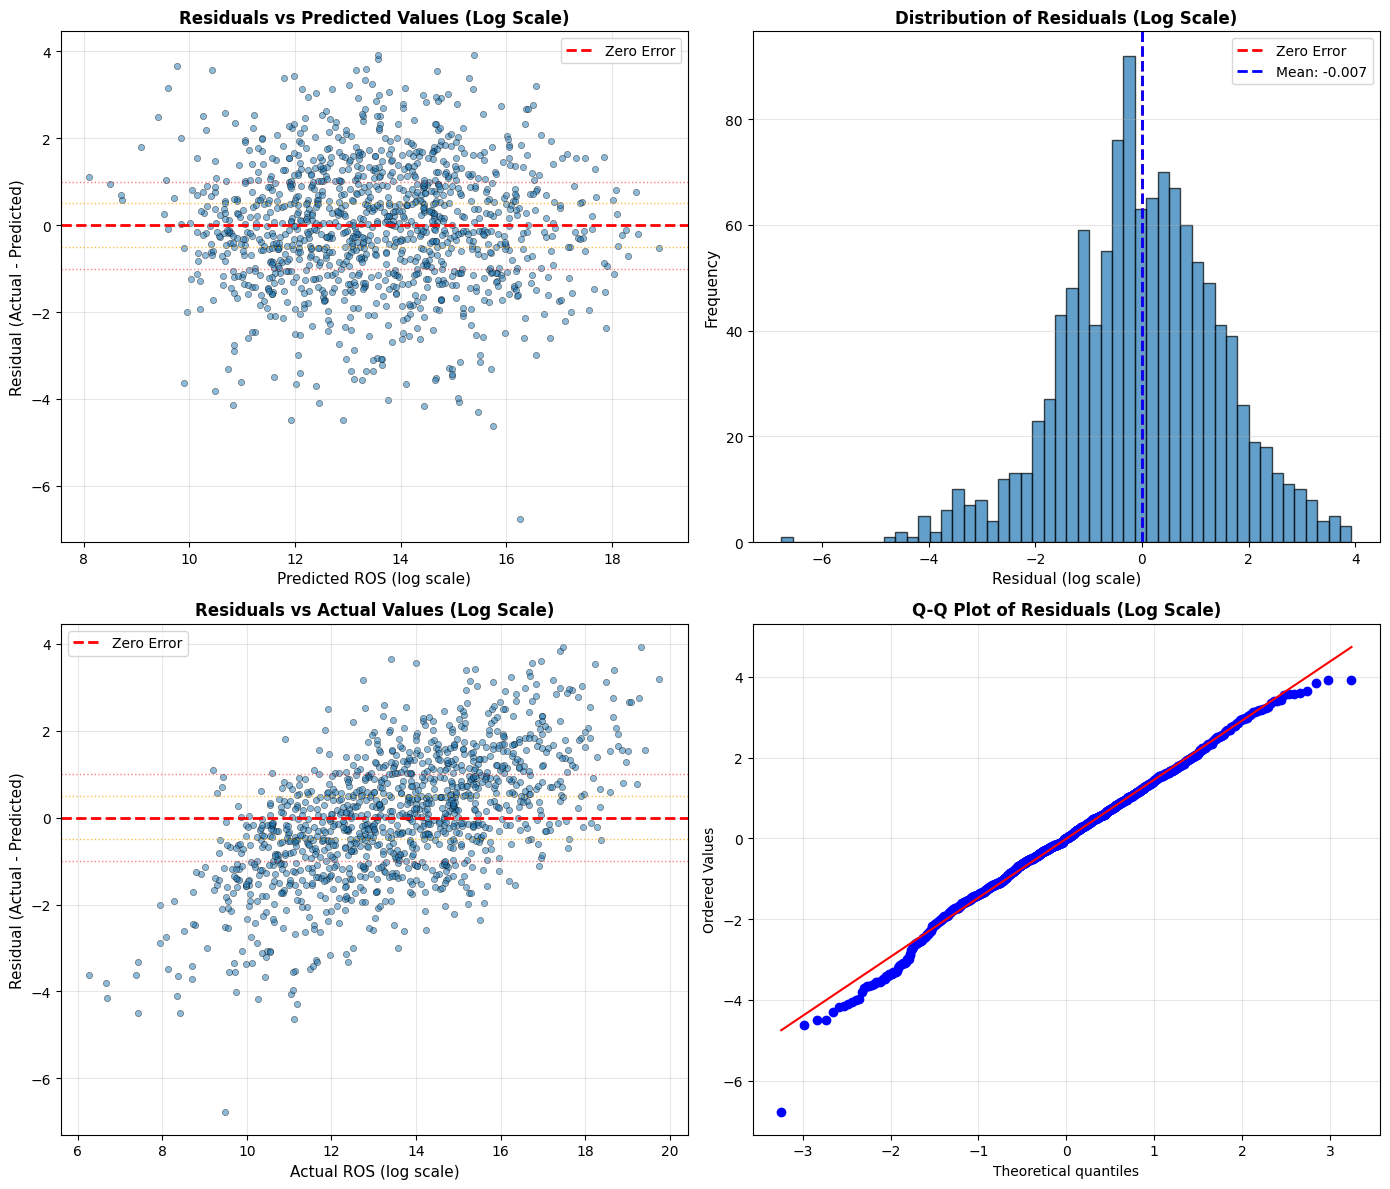

Residuals Plots (Linear Scale)


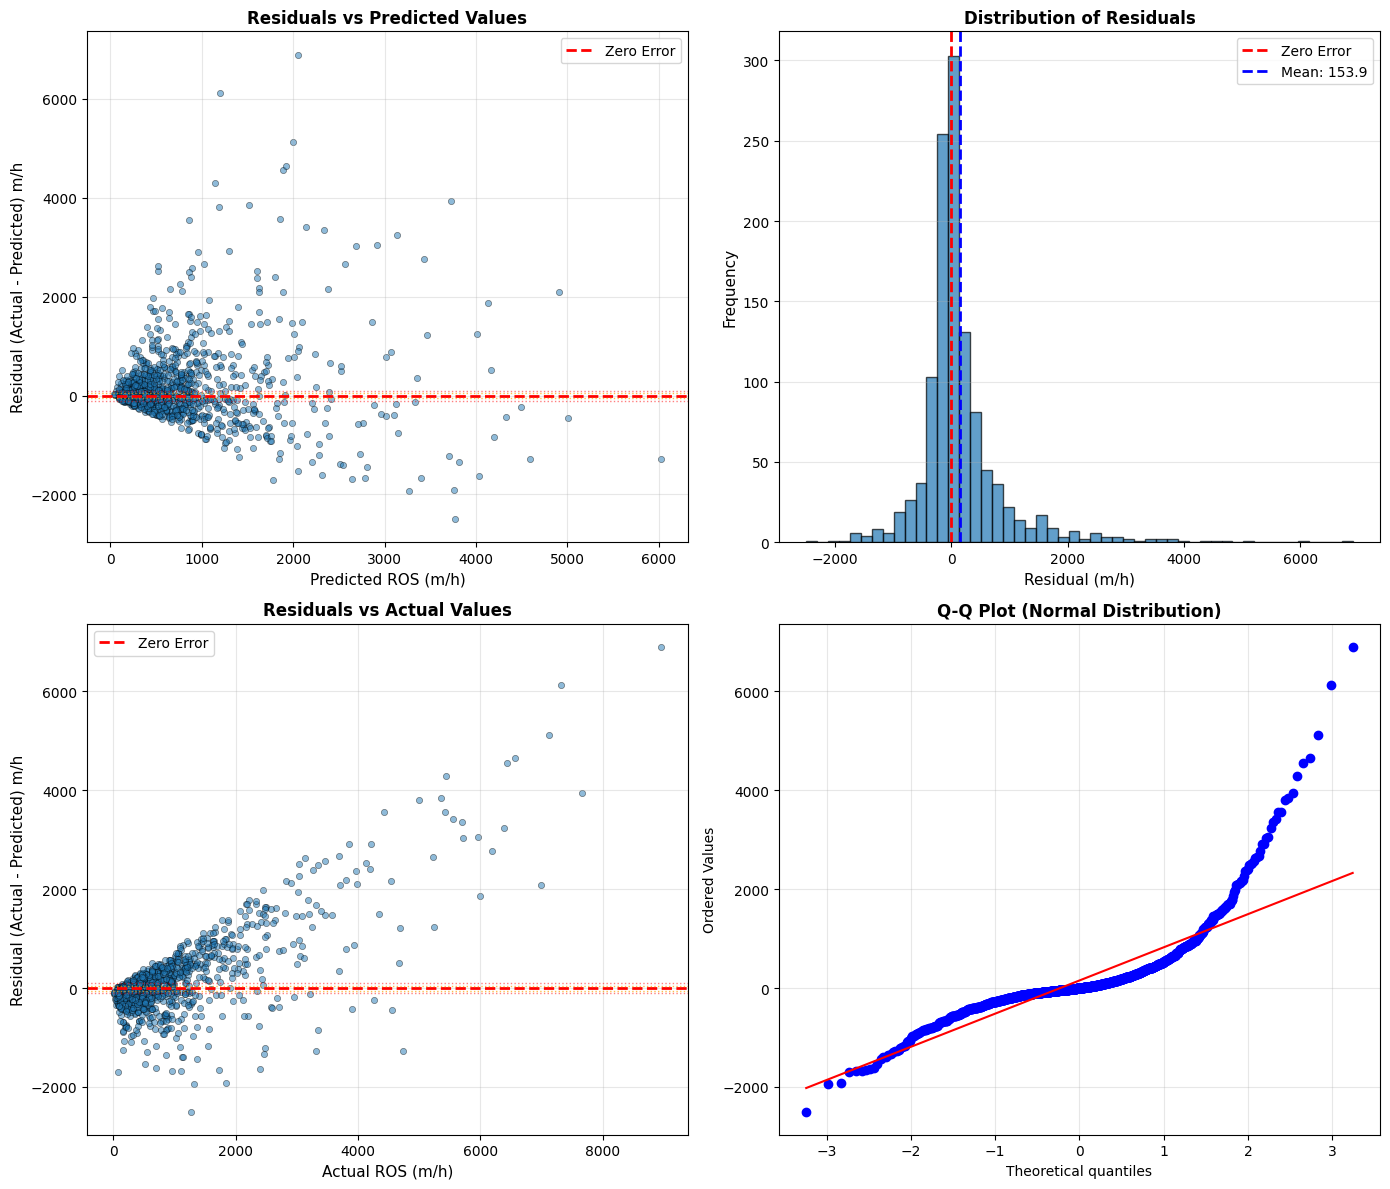


PERCENTAGE ERROR ANALYSIS (for actual ROS > 1 m/h):
Mean Percentage Error:    -28.68%
Median Percentage Error:  +0.37%
Std Dev Percentage Error: 121.64%

SYSTEMATIC BIAS DETECTED: Model tends to UNDERPREDICT by 153.9 m/h on average


In [113]:
print("\n" + "="*60)
print("RESIDUAL ANALYSIS")
print("="*60)

# Calculate residuals in both scales
residuals_log = all_y_test_log - all_y_pred_log
residuals_linear = all_y_test_linear - all_y_pred_linear

# Basic residual statistics - LOG SCALE
print("\nRESIDUAL STATISTICS (Log Scale):")
print(f"Mean Residual:        {np.mean(residuals_log):.4f}")
print(f"Median Residual:      {np.median(residuals_log):.4f}")
print(f"Std Dev Residual:     {np.std(residuals_log):.4f}")
print(f"Min Residual:         {np.min(residuals_log):.4f}")
print(f"Max Residual:         {np.max(residuals_log):.4f}")

# Basic residual statistics - LINEAR SCALE
print("\nRESIDUAL STATISTICS (Linear Scale):")
print(f"Mean Residual:        {np.mean(residuals_linear):.2f} m/h")
print(f"Median Residual:      {np.median(residuals_linear):.2f} m/h")
print(f"Std Dev Residual:     {np.std(residuals_linear):.2f} m/h")
print(f"Min Residual:         {np.min(residuals_linear):.2f} m/h")
print(f"Max Residual:         {np.max(residuals_linear):.2f} m/h")

# Percentage of predictions within certain error bounds - LOG SCALE
within_0_5_log = np.sum(np.abs(residuals_log) <= 0.5) / len(residuals_log) * 100
within_1_log = np.sum(np.abs(residuals_log) <= 1.0) / len(residuals_log) * 100
within_2_log = np.sum(np.abs(residuals_log) <= 2.0) / len(residuals_log) * 100

print(f"\nPredictions within ±0.5 (log):   {within_0_5_log:.1f}%")
print(f"Predictions within ±1.0 (log):   {within_1_log:.1f}%")
print(f"Predictions within ±2.0 (log):   {within_2_log:.1f}%")

# Percentage of predictions within certain error bounds - LINEAR SCALE
within_10 = np.sum(np.abs(residuals_linear) <= 10) / len(residuals_linear) * 100
within_50 = np.sum(np.abs(residuals_linear) <= 50) / len(residuals_linear) * 100
within_100 = np.sum(np.abs(residuals_linear) <= 100) / len(residuals_linear) * 100

print(f"\nPredictions within ±10 m/h:   {within_10:.1f}%")
print(f"Predictions within ±50 m/h:   {within_50:.1f}%")
print(f"Predictions within ±100 m/h:  {within_100:.1f}%")

# Systematic error analysis - binned predictions - LOG SCALE
print("\n" + "-"*60)
print("SYSTEMATIC ERROR ANALYSIS (by prediction magnitude - LOG SCALE):")
print("-"*60)

# Create bins for analysis in log space
bins_log = [0, 2, 4, 6, 8, 10, np.inf]
bin_labels_log = ['0-2', '2-4', '4-6', '6-8', '8-10', '10+']

# Assign bins to predictions
bin_indices_log = np.digitize(all_y_pred_log, bins_log) - 1

print(f"\n{'Range (log)':<15} {'Count':<10} {'Mean Error':<15} {'RMSE':<15}")
print("-" * 60)

for i, label in enumerate(bin_labels_log):
    mask = bin_indices_log == i
    if np.sum(mask) > 0:
        count = np.sum(mask)
        mean_error = np.mean(residuals_log[mask])
        rmse_bin = np.sqrt(np.mean(residuals_log[mask]**2))
        print(f"{label:<15} {count:<10} {mean_error:>+10.4f}       {rmse_bin:>10.4f}")

# Systematic error analysis - binned predictions - LINEAR SCALE
print("\n" + "-"*60)
print("SYSTEMATIC ERROR ANALYSIS (by prediction magnitude - LINEAR SCALE):")
print("-"*60)

# Create bins for analysis
bins = [0, 50, 100, 200, 500, 1000, np.inf]
bin_labels = ['0-50', '50-100', '100-200', '200-500', '500-1000', '1000+']

# Assign bins to predictions
bin_indices = np.digitize(all_y_pred_linear, bins) - 1

print(f"\n{'Range (m/h)':<15} {'Count':<10} {'Mean Error':<15} {'Mean % Error':<15} {'RMSE':<15}")
print("-" * 70)

for i, label in enumerate(bin_labels):
    mask = bin_indices == i
    if np.sum(mask) > 0:
        count = np.sum(mask)
        mean_error = np.mean(residuals_linear[mask])
        mean_pct_error = np.mean((residuals_linear[mask] / all_y_test_linear[mask]) * 100)
        rmse_bin = np.sqrt(np.mean(residuals_linear[mask]**2))
        print(f"{label:<15} {count:<10} {mean_error:>+10.2f} m/h  {mean_pct_error:>+10.1f}%     {rmse_bin:>10.2f} m/h")


# RESIDUAL PLOTS - LOG SCALE

print("Residual Plots (Log Scale)")

fig1, axes1 = plt.subplots(2, 2, figsize=(14, 12))

# Plot 1: Residuals vs Predicted Values (Log)
axes1[0, 0].scatter(all_y_pred_log, residuals_log, alpha=0.5, s=20, edgecolor='k', linewidth=0.5)
axes1[0, 0].axhline(y=0, color='r', linestyle='--', linewidth=2, label='Zero Error')
axes1[0, 0].set_xlabel('Predicted ROS (log scale)', fontsize=11)
axes1[0, 0].set_ylabel('Residual (Actual - Predicted)', fontsize=11)
axes1[0, 0].set_title('Residuals vs Predicted Values (Log Scale)', fontsize=12, fontweight='bold')
axes1[0, 0].grid(True, alpha=0.3)
axes1[0, 0].legend()

# Add reference lines for ±0.5, ±1.0 log units
axes1[0, 0].axhline(y=0.5, color='orange', linestyle=':', linewidth=1, alpha=0.7)
axes1[0, 0].axhline(y=-0.5, color='orange', linestyle=':', linewidth=1, alpha=0.7)
axes1[0, 0].axhline(y=1.0, color='red', linestyle=':', linewidth=1, alpha=0.5)
axes1[0, 0].axhline(y=-1.0, color='red', linestyle=':', linewidth=1, alpha=0.5)

# Plot 2: Histogram of Residuals (Log)
axes1[0, 1].hist(residuals_log, bins=50, edgecolor='black', alpha=0.7)
axes1[0, 1].axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero Error')
axes1[0, 1].axvline(x=np.mean(residuals_log), color='blue', linestyle='--', linewidth=2, label=f'Mean: {np.mean(residuals_log):.3f}')
axes1[0, 1].set_xlabel('Residual (log scale)', fontsize=11)
axes1[0, 1].set_ylabel('Frequency', fontsize=11)
axes1[0, 1].set_title('Distribution of Residuals (Log Scale)', fontsize=12, fontweight='bold')
axes1[0, 1].legend()
axes1[0, 1].grid(True, alpha=0.3, axis='y')

# Plot 3: Residuals vs Actual Values (Log)
axes1[1, 0].scatter(all_y_test_log, residuals_log, alpha=0.5, s=20, edgecolor='k', linewidth=0.5)
axes1[1, 0].axhline(y=0, color='r', linestyle='--', linewidth=2, label='Zero Error')
axes1[1, 0].set_xlabel('Actual ROS (log scale)', fontsize=11)
axes1[1, 0].set_ylabel('Residual (Actual - Predicted)', fontsize=11)
axes1[1, 0].set_title('Residuals vs Actual Values (Log Scale)', fontsize=12, fontweight='bold')
axes1[1, 0].grid(True, alpha=0.3)
axes1[1, 0].legend()

# Add reference lines
axes1[1, 0].axhline(y=0.5, color='orange', linestyle=':', linewidth=1, alpha=0.7)
axes1[1, 0].axhline(y=-0.5, color='orange', linestyle=':', linewidth=1, alpha=0.7)
axes1[1, 0].axhline(y=1.0, color='red', linestyle=':', linewidth=1, alpha=0.5)
axes1[1, 0].axhline(y=-1.0, color='red', linestyle=':', linewidth=1, alpha=0.5)

# Plot 4: Q-Q Plot (to check normality of residuals) - Log
from scipy import stats
stats.probplot(residuals_log, dist="norm", plot=axes1[1, 1])
axes1[1, 1].set_title('Q-Q Plot of Residuals (Log Scale)', fontsize=12, fontweight='bold')
axes1[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# RESIDUAL PLOTS - LINEAR SCALE

print("Residuals Plots (Linear Scale)")

# 1. Residual vs Predicted (Linear Scale)
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Plot 1: Residuals vs Predicted Values
axes[0, 0].scatter(all_y_pred_linear, residuals_linear, alpha=0.5, s=20, edgecolor='k', linewidth=0.5)
axes[0, 0].axhline(y=0, color='r', linestyle='--', linewidth=2, label='Zero Error')
axes[0, 0].set_xlabel('Predicted ROS (m/h)', fontsize=11)
axes[0, 0].set_ylabel('Residual (Actual - Predicted) m/h', fontsize=11)
axes[0, 0].set_title('Residuals vs Predicted Values', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()

# Add reference lines for ±50 and ±100 m/h errors
axes[0, 0].axhline(y=50, color='orange', linestyle=':', linewidth=1, alpha=0.7)
axes[0, 0].axhline(y=-50, color='orange', linestyle=':', linewidth=1, alpha=0.7)
axes[0, 0].axhline(y=100, color='red', linestyle=':', linewidth=1, alpha=0.5)
axes[0, 0].axhline(y=-100, color='red', linestyle=':', linewidth=1, alpha=0.5)

# Plot 2: Histogram of Residuals
axes[0, 1].hist(residuals_linear, bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero Error')
axes[0, 1].axvline(x=np.mean(residuals_linear), color='blue', linestyle='--', linewidth=2, label=f'Mean: {np.mean(residuals_linear):.1f}')
axes[0, 1].set_xlabel('Residual (m/h)', fontsize=11)
axes[0, 1].set_ylabel('Frequency', fontsize=11)
axes[0, 1].set_title('Distribution of Residuals', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Plot 3: Residuals vs Actual Values
axes[1, 0].scatter(all_y_test_linear, residuals_linear, alpha=0.5, s=20, edgecolor='k', linewidth=0.5)
axes[1, 0].axhline(y=0, color='r', linestyle='--', linewidth=2, label='Zero Error')
axes[1, 0].set_xlabel('Actual ROS (m/h)', fontsize=11)
axes[1, 0].set_ylabel('Residual (Actual - Predicted) m/h', fontsize=11)
axes[1, 0].set_title('Residuals vs Actual Values', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend()

# Add reference lines
axes[1, 0].axhline(y=50, color='orange', linestyle=':', linewidth=1, alpha=0.7)
axes[1, 0].axhline(y=-50, color='orange', linestyle=':', linewidth=1, alpha=0.7)
axes[1, 0].axhline(y=100, color='red', linestyle=':', linewidth=1, alpha=0.5)
axes[1, 0].axhline(y=-100, color='red', linestyle=':', linewidth=1, alpha=0.5)

# Plot 4: Q-Q Plot (to check normality of residuals)
from scipy import stats
stats.probplot(residuals_linear, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot (Normal Distribution)', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# PERCENTAGE ERROR ANALYSIS

# Calculate percentage errors 
mask_nonzero = all_y_test_linear > 1  # Only consider actual values > 1 m/h
pct_errors = (residuals_linear[mask_nonzero] / all_y_test_linear[mask_nonzero]) * 100

print("\n" + "="*60)
print("PERCENTAGE ERROR ANALYSIS (for actual ROS > 1 m/h):")
print("="*60)
print(f"Mean Percentage Error:    {np.mean(pct_errors):+.2f}%")
print(f"Median Percentage Error:  {np.median(pct_errors):+.2f}%")
print(f"Std Dev Percentage Error: {np.std(pct_errors):.2f}%")

# Systematic bias check
if np.abs(np.mean(residuals_linear)) > 5:
    if np.mean(residuals_linear) > 0:
        print(f"\nSYSTEMATIC BIAS DETECTED: Model tends to UNDERPREDICT by {np.mean(residuals_linear):.1f} m/h on average")
    else:
        print(f"\nSYSTEMATIC BIAS DETECTED: Model tends to OVERPREDICT by {np.abs(np.mean(residuals_linear)):.1f} m/h on average")
else:
    print(f"\n✓ No significant systematic bias detected (mean error: {np.mean(residuals_linear):.1f} m/h)")

### 95% quantile residuals

Loading dataset...
Dataset loaded

95th Percentile of Absolute Residuals (log): 3.0721
Number of outlier observations: 59 (5.0% of data)

------------------------------------------------------------------------------------------------------------------------
MATCHING ALL OBSERVATIONS TO ORIGINAL DATAFRAME...
------------------------------------------------------------------------------------------------------------------------

Successfully matched 1173 out of 1173 total observations

--------------------------------------------------------------------------------------------------------------------------------------------
TOP 50 WORST PREDICTIONS WITH ORIGINAL DATAFRAME INDICES:
--------------------------------------------------------------------------------------------------------------------------------------------
DF_Idx     CV_Idx   Actual(m/h)  Pred(m/h)    Error(m/h)   %Error     Abs_Res_Log 
---------------------------------------------------------------------------------------

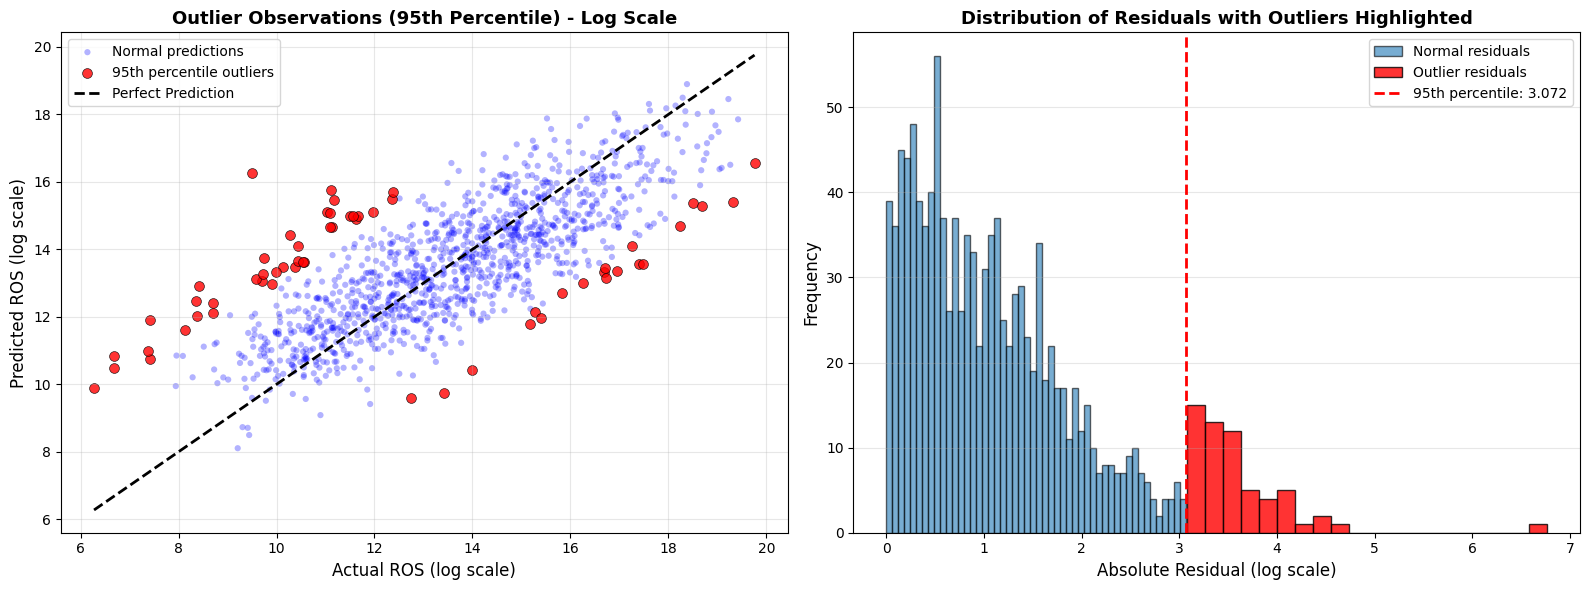

In [114]:
"""
Obter as observações com maiores residuos e assinalar no shp original 
para poder investigar pq é que o modelo está a falhar.

Primeiro vamos importar o shp "final" em vez do "model"
"""

print("Loading dataset...")

try:
    shp_path = '../../Data/Processed/PT-FireSprd_v2.1/L2_FireBehavior/PT-FireProg_v2.1_L2_final.shp'
    df = gpd.read_file(shp_path)
    print("Dataset loaded")

except Exception as e:
    print(f"Error loading dataset: {e}")
    raise


# Calculate absolute residuals in log scale
abs_residuals_log = np.abs(residuals_log)

# Find the 95th percentile threshold
percentile_95 = np.percentile(abs_residuals_log, 95)
print(f"\n95th Percentile of Absolute Residuals (log): {percentile_95:.4f}")

# Find observations beyond 95th percentile
outlier_mask = abs_residuals_log >= percentile_95
outlier_indices = np.where(outlier_mask)[0]

print(f"Number of outlier observations: {len(outlier_indices)} ({len(outlier_indices)/len(residuals_log)*100:.1f}% of data)")

# Create a dataframe with outlier details
outlier_data = pd.DataFrame({
    'CV_Index': outlier_indices,
    'Actual_Log': all_y_test_log[outlier_mask],
    'Predicted_Log': all_y_pred_log[outlier_mask],
    'Residual_Log': residuals_log[outlier_mask],
    'Abs_Residual_Log': abs_residuals_log[outlier_mask],
    'Actual_Linear': all_y_test_linear[outlier_mask],
    'Predicted_Linear': all_y_pred_linear[outlier_mask],
    'Residual_Linear': residuals_linear[outlier_mask],
    'Percent_Error': (residuals_linear[outlier_mask] / all_y_test_linear[outlier_mask]) * 100
})

# Sort by absolute residual (largest errors first)
outlier_data = outlier_data.sort_values('Abs_Residual_Log', ascending=False)

print("\n" + "-"*120)
print("MATCHING ALL OBSERVATIONS TO ORIGINAL DATAFRAME...")
print("-"*120)

# Match ALL observations back to original dataframe using ros_p values
# Create a complete dataframe with all predictions
all_predictions = pd.DataFrame({
    'CV_Index': np.arange(len(all_y_test_linear)),
    'Actual_Linear': all_y_test_linear,
    'Predicted_Linear': all_y_pred_linear,
    'Residual_Linear': residuals_linear,
    'Percent_Error': (residuals_linear / all_y_test_linear) * 100,
    'Abs_Residual_Log': abs_residuals_log
})

matched_all = []

for idx, row in all_predictions.iterrows():
    actual_ros = row['Actual_Linear']
    
    # Find matching rows in original df with same ros_p value
    # Use a small tolerance for floating point comparison
    tolerance = 0.01
    matches = df[np.abs(df['ros_p'] - actual_ros) < tolerance]
    
    if len(matches) > 0:
        # If multiple matches, try to narrow down by taking first match
        match_idx = matches.index[0]
        
        matched_all.append({
            'DF_Index': match_idx,
            'CV_Index': row['CV_Index'],
            'Actual_ROS': actual_ros,
            'Predicted_ROS': row['Predicted_Linear'],
            'Error': row['Residual_Linear'],
            'Percent_Error': row['Percent_Error'],
            'Abs_Residual_Log': row['Abs_Residual_Log']
        })
    else:
        # If no exact match found, still record it
        matched_all.append({
            'DF_Index': 'NOT_FOUND',
            'CV_Index': row['CV_Index'],
            'Actual_ROS': actual_ros,
            'Predicted_ROS': row['Predicted_Linear'],
            'Error': row['Residual_Linear'],
            'Percent_Error': row['Percent_Error'],
            'Abs_Residual_Log': row['Abs_Residual_Log']
        })

matched_df_all = pd.DataFrame(matched_all)

print(f"\nSuccessfully matched {len(matched_df_all[matched_df_all['DF_Index'] != 'NOT_FOUND'])} out of {len(matched_df_all)} total observations")

print("\n" + "-"*140)
print("TOP 50 WORST PREDICTIONS WITH ORIGINAL DATAFRAME INDICES:")
print("-"*140)
print(f"{'DF_Idx':<10} {'CV_Idx':<8} {'Actual(m/h)':<12} {'Pred(m/h)':<12} {'Error(m/h)':<12} {'%Error':<10} {'Abs_Res_Log':<12}")
print("-"*140)

# Show outliers only for this summary
matched_df_outliers = matched_df_all[matched_df_all['Abs_Residual_Log'] >= percentile_95].sort_values('Abs_Residual_Log', ascending=False)

for idx, row in matched_df_outliers.head(50).iterrows():
    df_idx_str = str(row['DF_Index']) if row['DF_Index'] != 'NOT_FOUND' else 'NOT_FOUND'
    print(f"{df_idx_str:<10} "
          f"{int(row['CV_Index']):<8} "
          f"{row['Actual_ROS']:>11.1f} "
          f"{row['Predicted_ROS']:>11.1f} "
          f"{row['Error']:>+11.1f} "
          f"{row['Percent_Error']:>+9.1f}% "
          f"{row['Abs_Residual_Log']:>11.4f}")


# ADD PREDICTION INFORMATION TO ALL OBSERVATIONS IN ORIGINAL DATAFRAME

print("\n" + "="*60)
print("ADDING PREDICTIONS TO ALL OBSERVATIONS IN DATAFRAME")
print("="*60)

# Initialize outlier column as False for all rows
df['outlier'] = False

# Initialize prediction columns with NaN
df['Pred_ROS'] = np.nan
df['Pred_Error'] = np.nan
df['Pct_Error'] = np.nan

# Get all valid indices
valid_all_indices = matched_df_all[matched_df_all['DF_Index'] != 'NOT_FOUND']['DF_Index'].tolist()

if len(valid_all_indices) > 0:
    # Add prediction information for ALL observations
    matched_valid = matched_df_all[matched_df_all['DF_Index'] != 'NOT_FOUND']
    
    df.loc[valid_all_indices, 'Pred_ROS'] = matched_valid['Predicted_ROS'].values
    df.loc[valid_all_indices, 'Pred_Error'] = matched_valid['Error'].values
    df.loc[valid_all_indices, 'Pct_Error'] = matched_valid['Percent_Error'].values
    
    # Mark outliers as True
    valid_outlier_indices = matched_valid[matched_valid['Abs_Residual_Log'] >= percentile_95]['DF_Index'].tolist()
    df.loc[valid_outlier_indices, 'outlier'] = True
    
    print(f"\nAdded predictions to {len(valid_all_indices)} observations in the dataframe")
    print(f"Marked {len(valid_outlier_indices)} observations as outliers (95th percentile)")
    print(f"Added columns: 'outlier', 'Pred_ROS', 'Pred_Error', 'Pct_Error'")
    
    # Statistical summary of all predictions
    all_with_pred = df[~df['Pred_ROS'].isna()]
    outlier_subset = df[df['outlier'] == True]
    
    print("\n" + "-"*60)
    print("OVERALL PREDICTION STATISTICS:")
    print("-"*60)
    print(f"Total observations in df:            {len(df)}")
    print(f"Observations with predictions:       {len(all_with_pred)} ({len(all_with_pred)/len(df)*100:.2f}%)")
    print(f"Number of outliers:                  {len(outlier_subset)} ({len(outlier_subset)/len(all_with_pred)*100:.2f}%)")
    print(f"\nAll Predictions:")
    print(f"  Mean Actual ROS:                   {all_with_pred['ros_p'].mean():.1f} m/h")
    print(f"  Mean Predicted ROS:                {all_with_pred['Pred_ROS'].mean():.1f} m/h")
    print(f"  Mean Absolute Error:               {np.abs(all_with_pred['Pred_Error']).mean():.1f} m/h")
    print(f"  Mean Percentage Error:             {all_with_pred['Pct_Error'].mean():+.1f}%")
    
    print(f"\nOutliers Only (95th percentile):")
    print(f"  Mean Actual ROS:                   {outlier_subset['ros_p'].mean():.1f} m/h")
    print(f"  Mean Predicted ROS:                {outlier_subset['Pred_ROS'].mean():.1f} m/h")
    print(f"  Mean Absolute Error:               {np.abs(outlier_subset['Pred_Error']).mean():.1f} m/h")
    print(f"  Mean Percentage Error:             {outlier_subset['Pct_Error'].mean():+.1f}%")
    
    # Check if model tends to over or underpredict
    all_underpred = all_with_pred[all_with_pred['Pred_Error'] > 0]
    all_overpred = all_with_pred[all_with_pred['Pred_Error'] < 0]
    
    print(f"\nOverall Prediction Bias:")
    print(f"  Underpredictions (model too low):  {len(all_underpred)} ({len(all_underpred)/len(all_with_pred)*100:.1f}%)")
    print(f"  Overpredictions (model too high):  {len(all_overpred)} ({len(all_overpred)/len(all_with_pred)*100:.1f}%)")
    
    # Check for outliers
    underpredictions = outlier_subset[outlier_subset['Pred_Error'] > 0]
    overpredictions = outlier_subset[outlier_subset['Pred_Error'] < 0]
    
    print(f"\nOutlier Prediction Bias:")
    print(f"  Underpredictions (model too low):  {len(underpredictions)} ({len(underpredictions)/len(outlier_subset)*100:.1f}%)")
    print(f"  Overpredictions (model too high):  {len(overpredictions)} ({len(overpredictions)/len(outlier_subset)*100:.1f}%)")
    
    # Display key features for top 10 worst predictions
    print("\n" + "-"*60)
    print("TOP 10 WORST PREDICTIONS - KEY FEATURES:")
    print("-"*60)
    
    # Select important columns to display
    display_cols = ['ros_p', 'Pred_ROS', 'Pred_Error', 'Pct_Error', 'outlier']
    
    # Add some feature columns if they exist
    possible_features = ['inidoy', 'enddoy', 'wind_speed', 'temperature', 'humidity', 
                        'fuel_type', 'slope', 'aspect']
    for col in possible_features:
        if col in df.columns:
            display_cols.append(col)
    
    # Get columns that actually exist
    display_cols = [col for col in display_cols if col in df.columns]
    
    print("\nShowing available columns:", display_cols)
    
    # Get top 10 worst predictions (sort by absolute error)
    top_outliers = outlier_subset.reindex(valid_outlier_indices).head(10)
    print(top_outliers[display_cols].to_string(index=True))
    
    # Save the complete dataframe with outlier flags to shapefile
    save_shp = True  
    if save_shp:
        output_path = '../../Data/Processed/PT-FireSprd_v2.1/L2_FireBehavior/PT-FireProg_v2.1_L2_final_with_outliers.shp'
        
        # Shapefile column names are limited to 10 characters, so we need to handle this
        # Create a copy with shorter column names if necessary
        df_to_save = df.copy()
        
        # Rename new columns to fit shapefile constraints (max 10 chars)
        column_mapping = {
            'Pred_ROS': 'PredROS',
            'Pred_Error': 'PredErr',
            'Pct_Error': 'PctErr'
        }
        df_to_save.rename(columns=column_mapping, inplace=True)
        
        df_to_save.to_file(output_path)
        print(f"\n✓ Complete dataframe with predictions saved to:")
        print(f"  {output_path}")
        print(f"\nNew columns added to ALL observations with predictions:")
        print(f"  - outlier: Boolean (True for 95th percentile worst predictions)")
        print(f"  - PredROS: Predicted ROS value (m/h) - ALL observations")
        print(f"  - PredErr: Prediction error (Actual - Predicted) - ALL observations")
        print(f"  - PctErr: Percentage error - ALL observations")
    else:
        print("\n💡 To save the shapefile with predictions, set save_shp = True")
    
    # Create a reference variable for easy access
    print("\n" + "="*60)
    print("QUICK ACCESS:")
    print("="*60)
    print("To access observations with predictions: df[~df['Pred_ROS'].isna()]")
    print("To access outliers: df[df['outlier'] == True]")
    print("To access normal observations: df[df['outlier'] == False]")
    print("Or examine specific observations: df.loc[<DF_Index>]")
    
else:
    print("\nWarning: Could not match observations back to original dataframe")
    print("This might happen if ros_p values were modified or filtered differently")

# Visualize outliers
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Scatter plot highlighting outliers
axes[0].scatter(all_y_test_log[~outlier_mask], all_y_pred_log[~outlier_mask], 
                alpha=0.3, s=20, c='blue', label='Normal predictions', edgecolor='none')
axes[0].scatter(all_y_test_log[outlier_mask], all_y_pred_log[outlier_mask], 
                alpha=0.8, s=50, c='red', label='95th percentile outliers', edgecolor='black', linewidth=0.5)

# Perfect prediction line
min_val = min(all_y_test_log.min(), all_y_pred_log.min())
max_val = max(all_y_test_log.max(), all_y_pred_log.max())
axes[0].plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=2, label='Perfect Prediction')

axes[0].set_xlabel('Actual ROS (log scale)', fontsize=12)
axes[0].set_ylabel('Predicted ROS (log scale)', fontsize=12)
axes[0].set_title('Outlier Observations (95th Percentile) - Log Scale', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Distribution comparison
axes[1].hist(abs_residuals_log[~outlier_mask], bins=50, alpha=0.6, label='Normal residuals', edgecolor='black')
axes[1].hist(abs_residuals_log[outlier_mask], bins=20, alpha=0.8, color='red', label='Outlier residuals', edgecolor='black')
axes[1].axvline(x=percentile_95, color='red', linestyle='--', linewidth=2, label=f'95th percentile: {percentile_95:.3f}')
axes[1].set_xlabel('Absolute Residual (log scale)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Distribution of Residuals with Outliers Highlighted', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### SHAP


SHAP Analysis


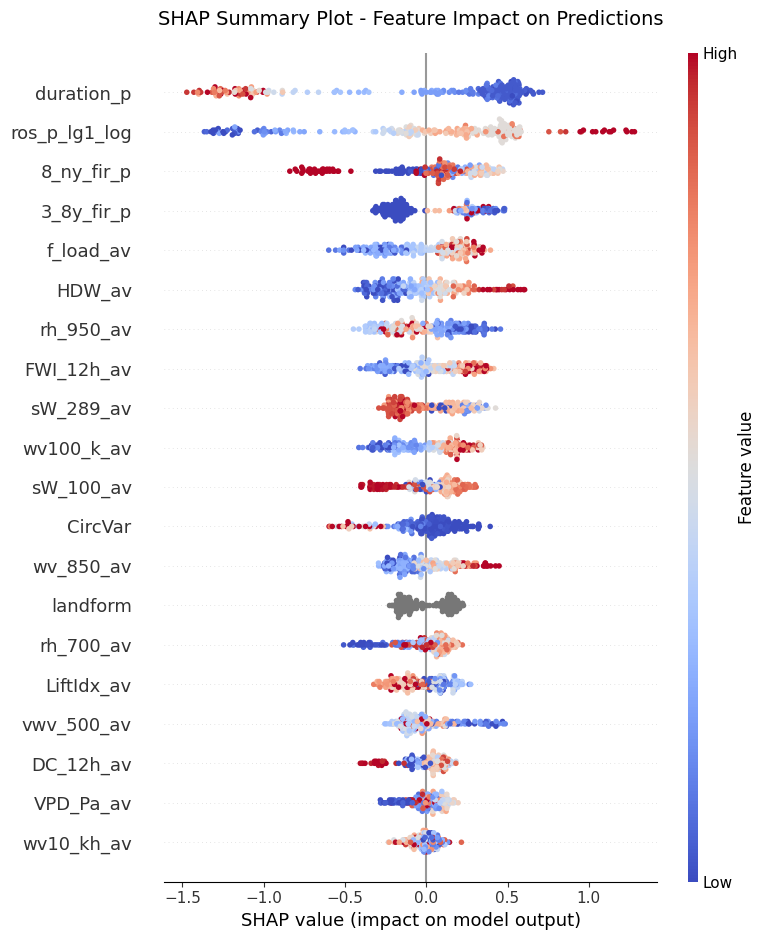

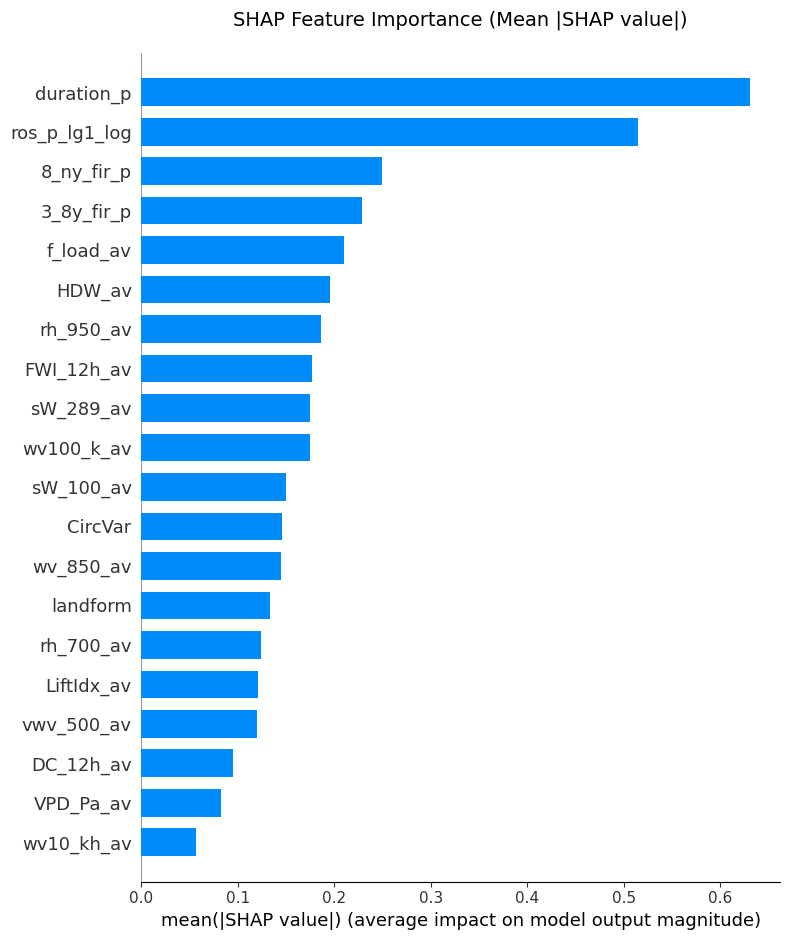


Generating waterfall plots for sample predictions...


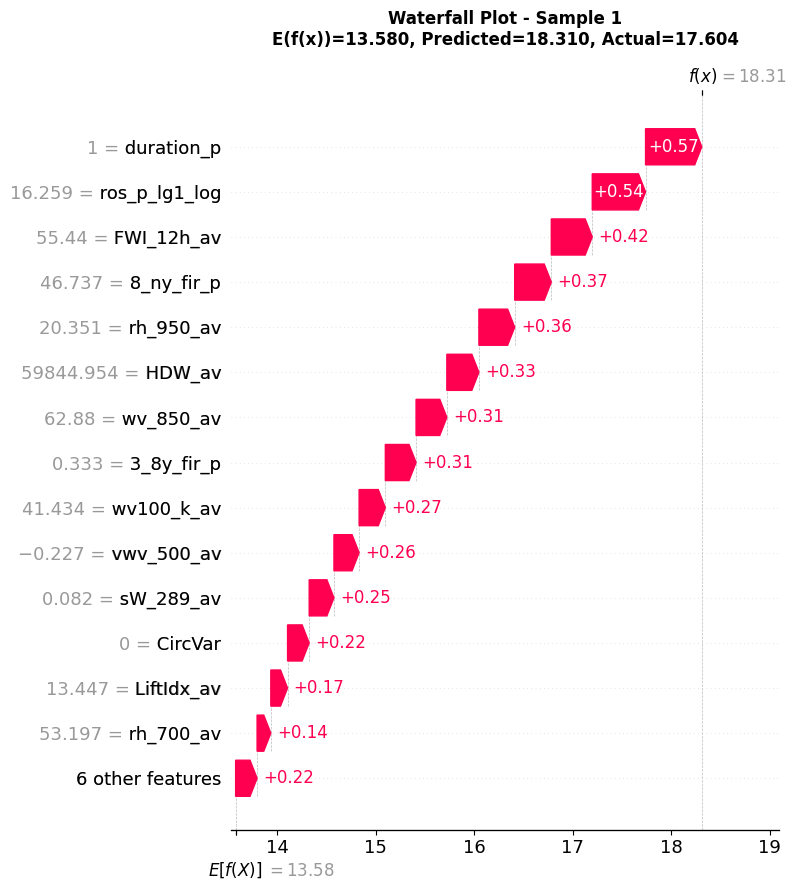

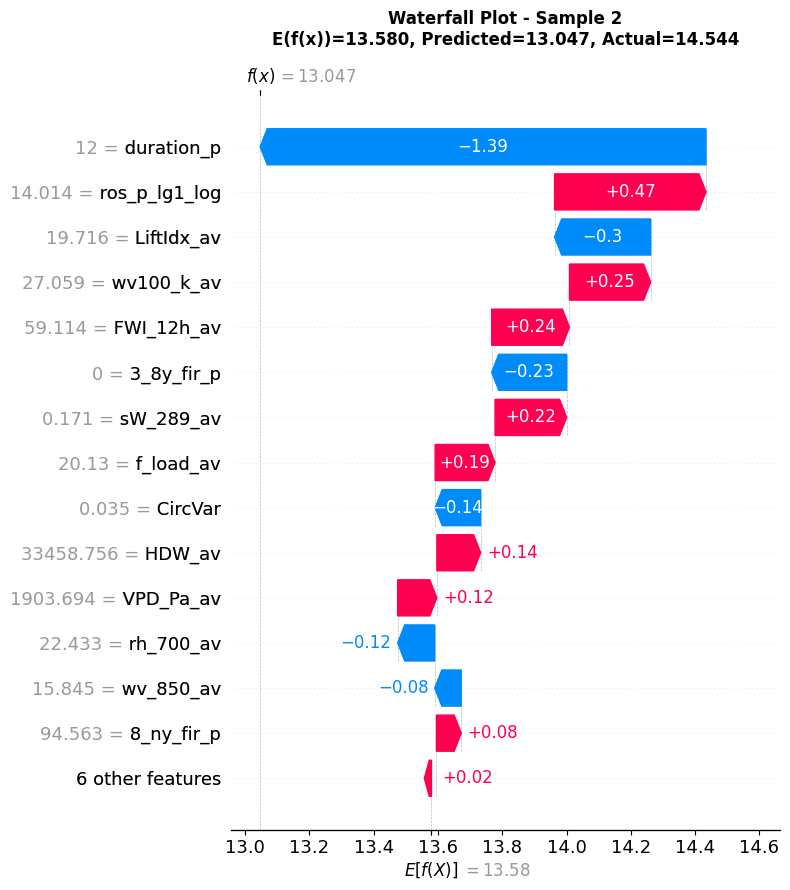

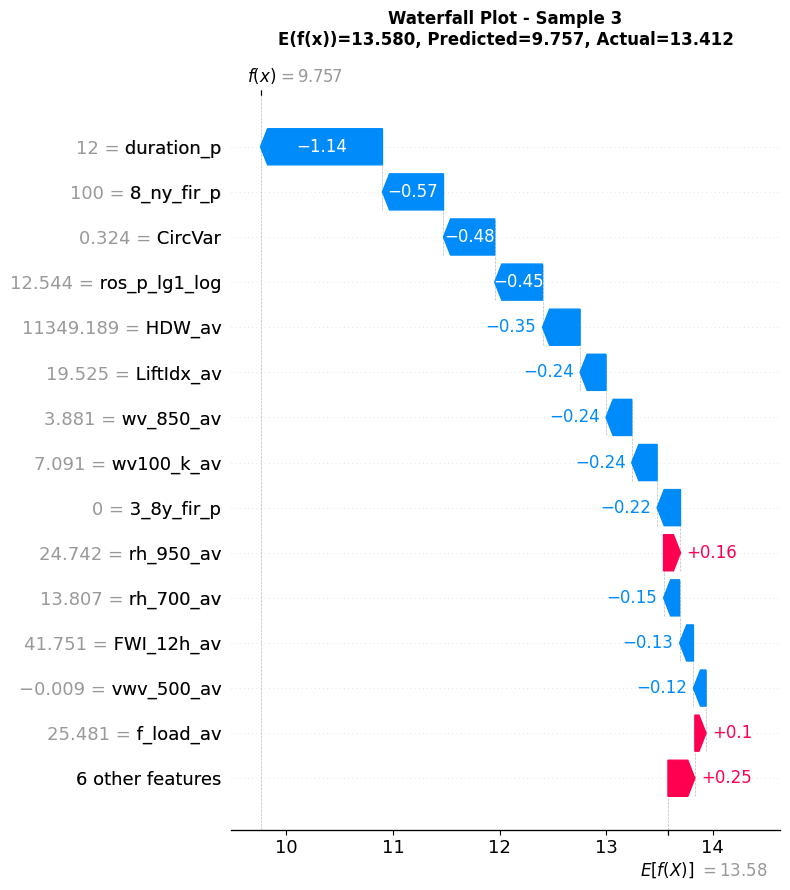

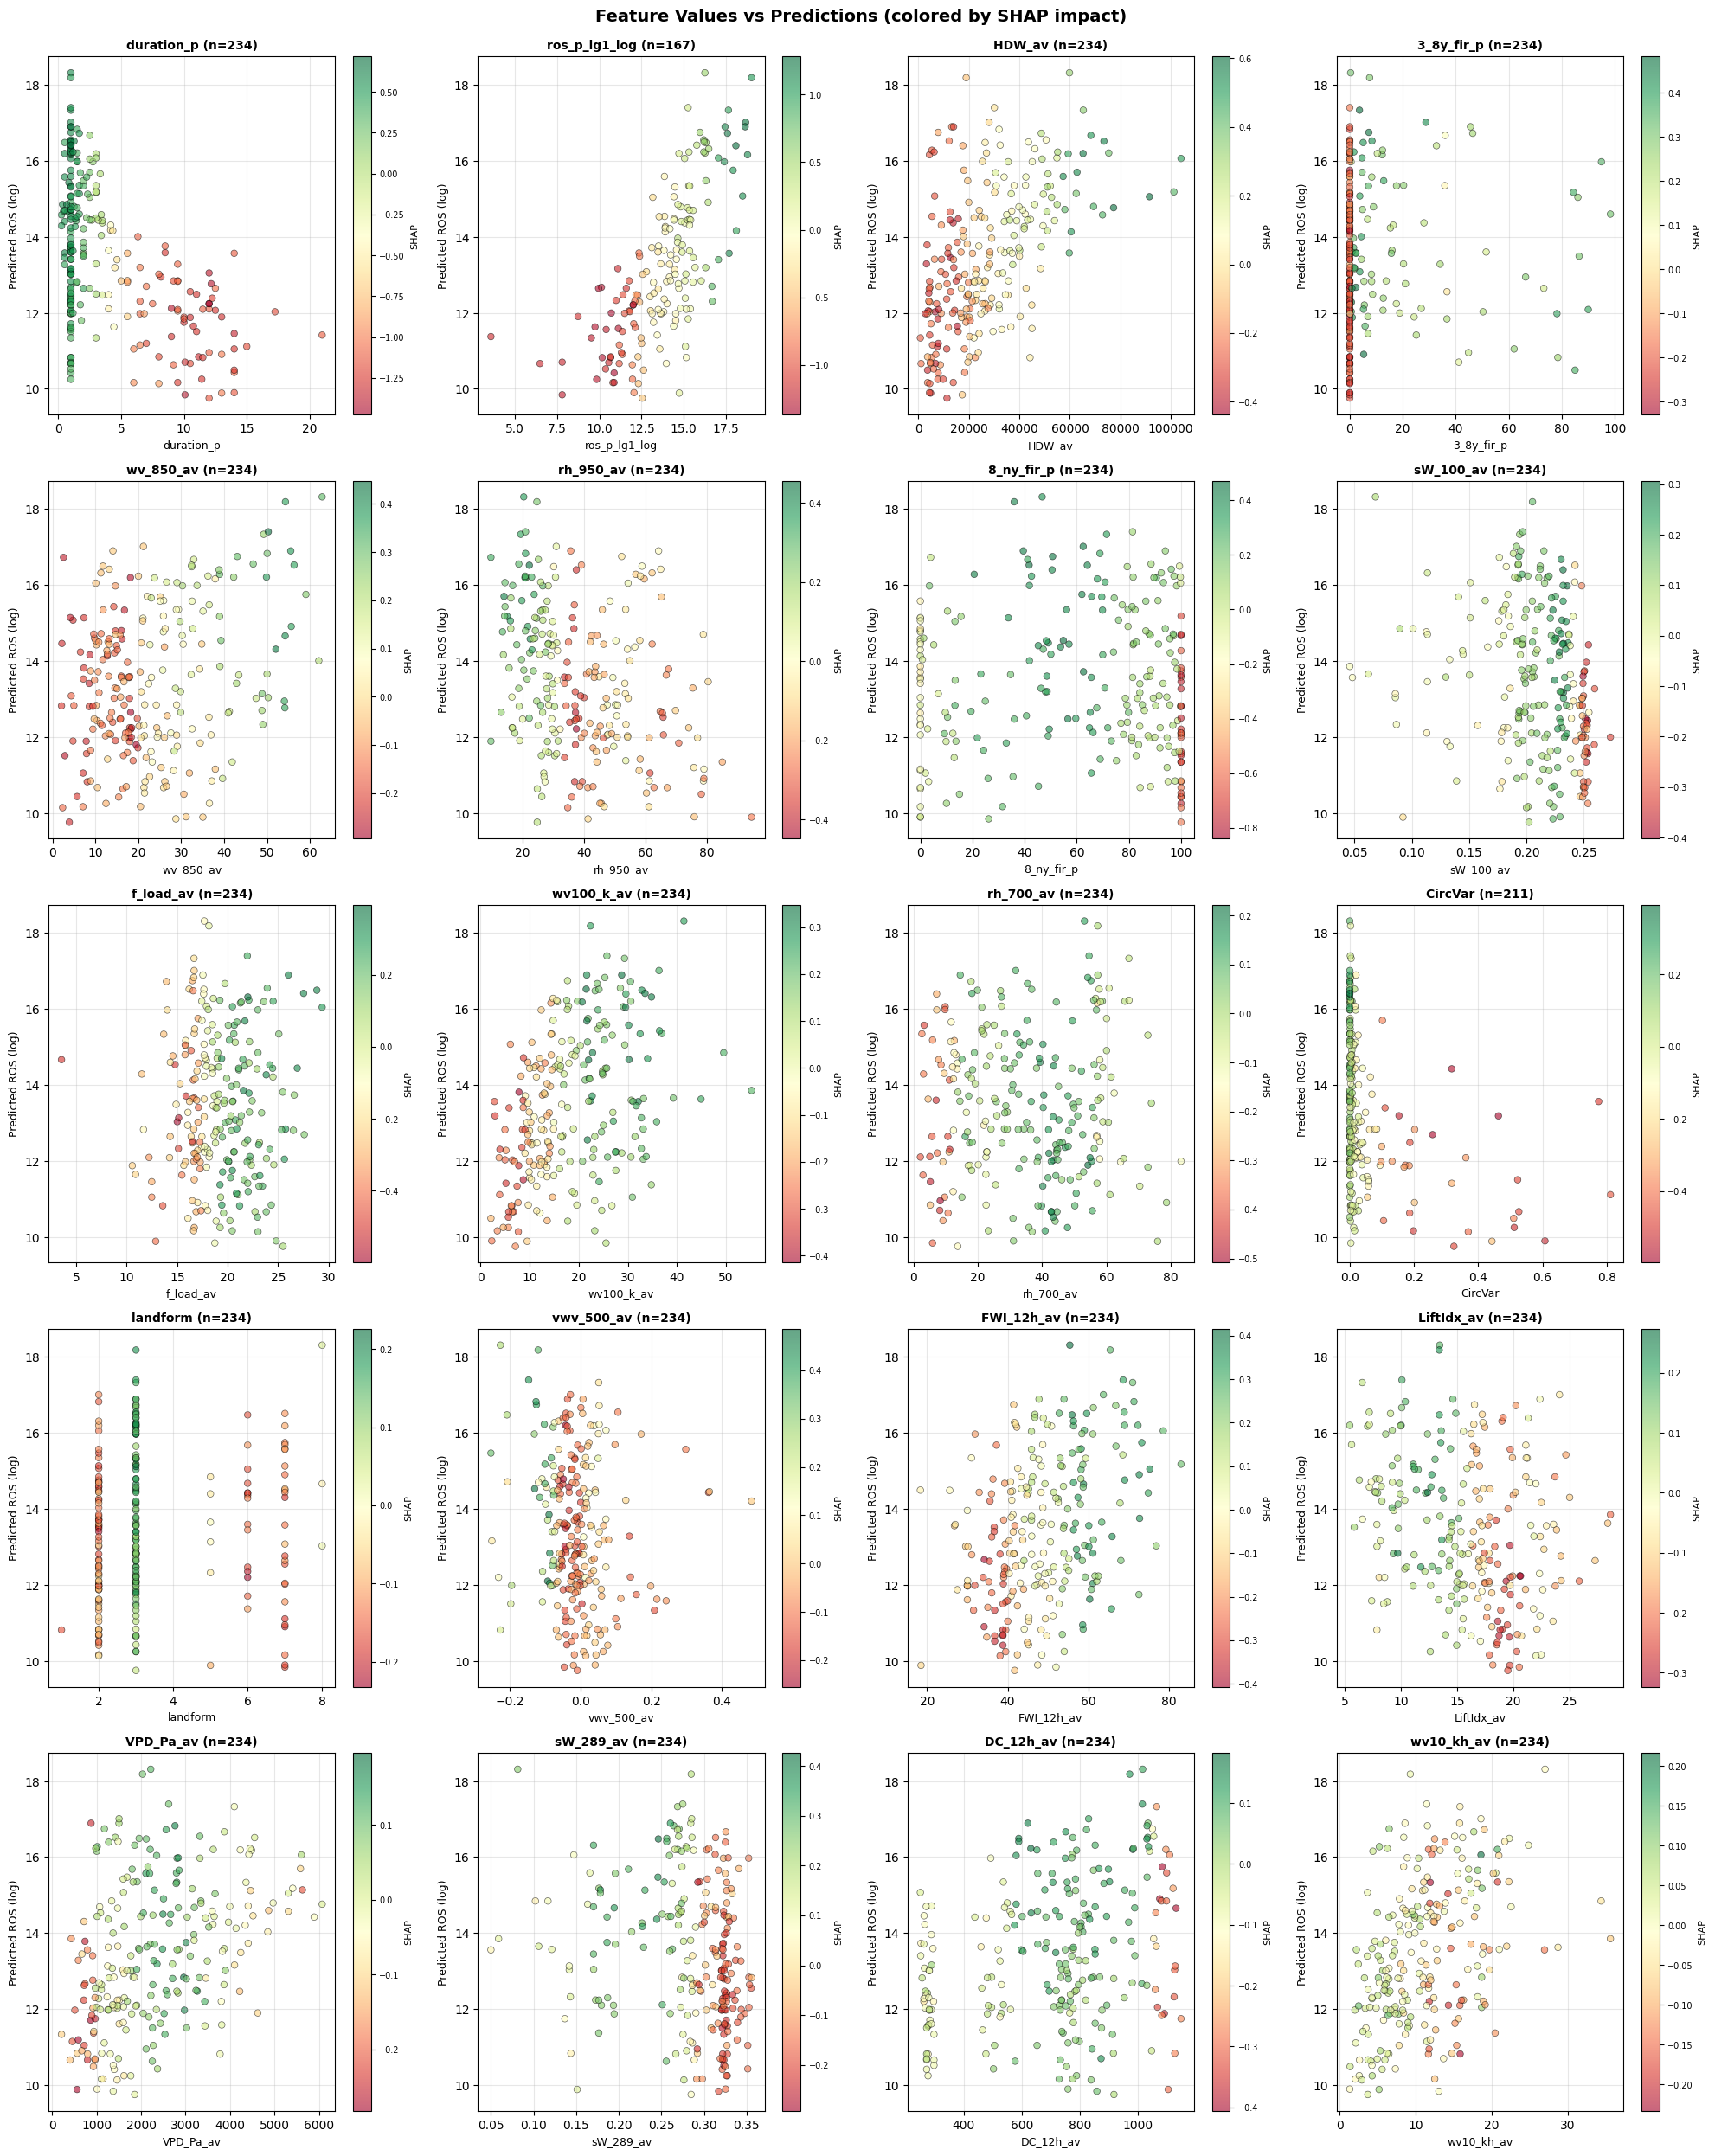

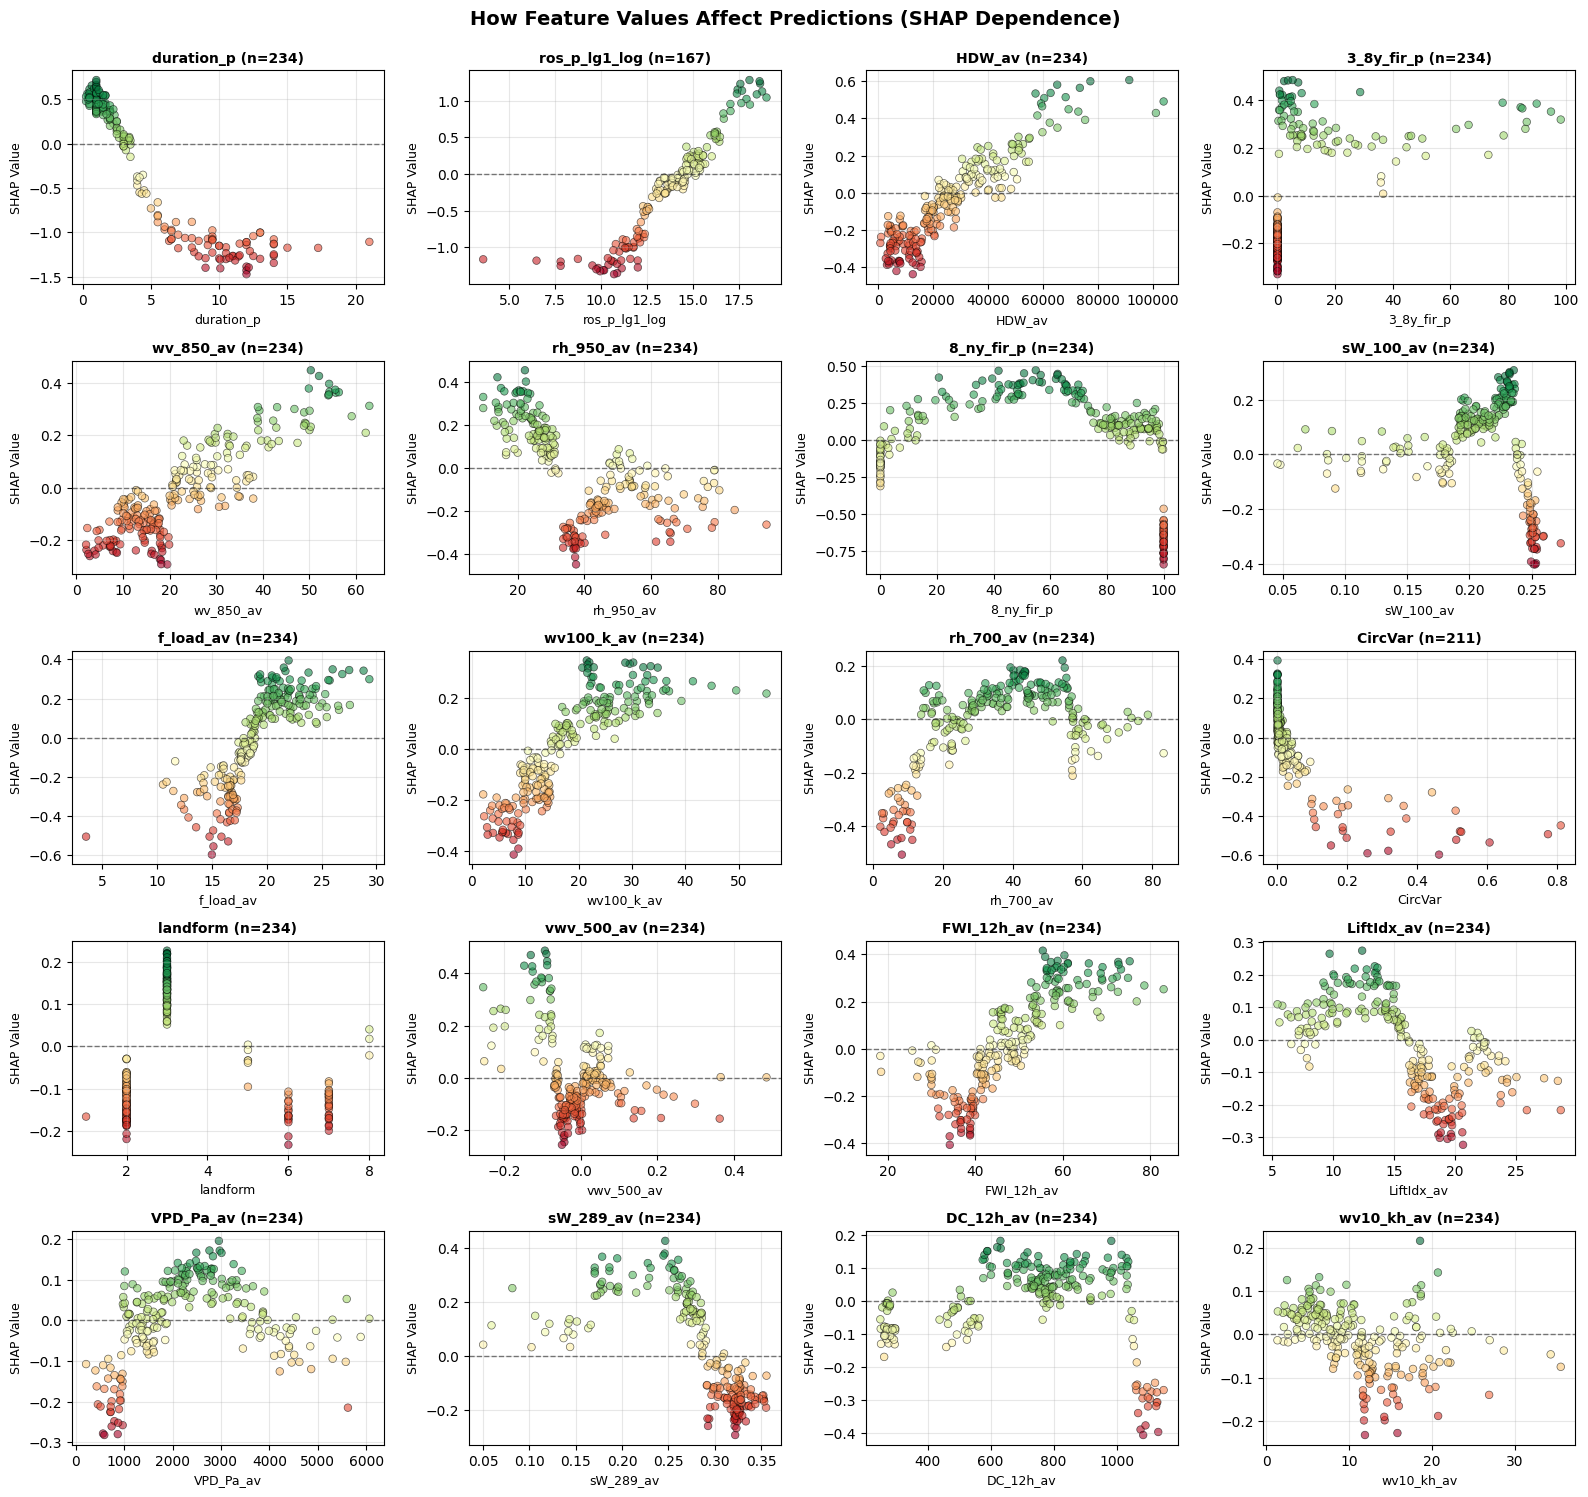


Top 20 Features by Mean |SHAP value|:
          feature  mean_abs_shap
0      duration_p       0.630426
1   ros_p_lg1_log       0.514381
6      8_ny_fir_p       0.249858
3      3_8y_fir_p       0.228592
8       f_load_av       0.209808
2          HDW_av       0.195472
5       rh_950_av       0.185859
14     FWI_12h_av       0.177210
17      sW_289_av       0.174490
9      wv100_k_av       0.174339
7       sW_100_av       0.149332
11        CircVar       0.145919
4       wv_850_av       0.144139
12       landform       0.133315
10      rh_700_av       0.123650
15     LiftIdx_av       0.120801
13     vwv_500_av       0.120129
18      DC_12h_av       0.094388
16      VPD_Pa_av       0.082090
19     wv10_kh_av       0.056897

Comparison: XGBoost Importance vs SHAP Importance (Top 15):
          feature  importance  mean_abs_shap
8      duration_p    0.111128       0.630426
13  ros_p_lg1_log    0.116315       0.514381
1      8_ny_fir_p    0.040163       0.249858
0      3_8y_fir_p    0.0438

In [115]:
"""
This code block generates SHAP analysis plots. Helps understand feature importance and effects.
"""

print("\n" + "="*50)
print("SHAP Analysis")
print("="*50)

# Create SHAP explainer
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test_final)

# 1. Summary Plot - properly handle categorical columns for display
# Create a copy for display that handles NaN coloring
X_test_display = X_test_final.copy()
for col in X_test_display.columns:
    if X_test_display[col].isna().any():
        # Check if column is categorical
        if X_test_display[col].dtype.name == 'category':
            # For categorical, fill with mode (most frequent value)
            mode_val = X_test_display[col].mode()[0] if len(X_test_display[col].mode()) > 0 else X_test_display[col].iloc[0]
            X_test_display[col] = X_test_display[col].fillna(mode_val)
        else:
            # For numeric, fill with median
            X_test_display[col] = X_test_display[col].fillna(X_test_display[col].median())

plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_display, plot_type="dot", show=False, cmap='coolwarm')
plt.title('SHAP Summary Plot - Feature Impact on Predictions', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

# 2. Bar Plot (alternative view of feature importance)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_display, plot_type="bar", show=False)
plt.title('SHAP Feature Importance (Mean |SHAP value|)', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

# 3. Waterfall Plot - Shows E(f(x)) and individual feature contributions
# Select a few interesting examples to explain
print("\nGenerating waterfall plots for sample predictions...")

# Pick 3 diverse examples: high, medium, low predictions
pred_indices = [
    y_pred_log.argmax(),  # Highest prediction
    len(y_pred_log) // 2,  # Middle prediction
    y_pred_log.argmin()   # Lowest prediction
]

# Create separate plots for each waterfall (they need their own figure)
for idx, pred_idx in enumerate(pred_indices):
    plt.figure(figsize=(10, 8))
    
    # Create waterfall plot for this prediction
    shap.waterfall_plot(
        shap.Explanation(
            values=shap_values[pred_idx],
            base_values=explainer.expected_value,
            data=X_test_display.iloc[pred_idx],
            feature_names=X_test_final.columns.tolist()
        ),
        max_display=15,
        show=False
    )
    
    actual_val = y_test_log.iloc[pred_idx] if hasattr(y_test_log, 'iloc') else y_test_log[pred_idx]
    pred_val = y_pred_log[pred_idx]
    
    plt.title(f'Waterfall Plot - Sample {idx+1}\n'
              f'E(f(x))={explainer.expected_value:.3f}, '
              f'Predicted={pred_val:.3f}, Actual={actual_val:.3f}',
              fontsize=12, fontweight='bold', pad=15)
    plt.tight_layout()
    plt.show()

# Get all features
all_features = X_test_final.columns.tolist()
n_features = len(all_features)

# Dynamically calculate rows and columns for subplots
n_cols = 4  # keep 4 columns
n_rows = math.ceil(n_features / n_cols)

# -----------------------------
# 1. Scatter Plots: Feature vs Prediction (colored by SHAP)
# -----------------------------
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))
axes = axes.flatten()

for idx, feature in enumerate(all_features):
    ax = axes[idx]
    
    # Feature values and SHAP values
    feature_values = X_test_final[feature].values
    feature_shap = shap_values[:, X_test_final.columns.get_loc(feature)]
    
    # Handle different data types for cleaning
    if X_test_final[feature].dtype.name == 'category' or X_test_final[feature].dtype == 'object':
        # For categorical data, check for NaN/None values
        valid_mask = pd.notna(feature_values)
        feature_values_clean = feature_values[valid_mask]
        feature_shap_clean = feature_shap[valid_mask]
        y_pred_clean = y_pred_log[valid_mask]
        
        # Convert categorical to numeric for plotting if needed
        if X_test_final[feature].dtype.name == 'category':
            feature_values_clean = pd.Categorical(feature_values_clean).codes
    else:
        # For numerical data, use the original approach
        valid_mask = ~np.isnan(feature_values)
        feature_values_clean = feature_values[valid_mask]
        feature_shap_clean = feature_shap[valid_mask]
        y_pred_clean = y_pred_log[valid_mask]
    
    # Scatter plot
    scatter = ax.scatter(
        feature_values_clean,
        y_pred_clean,
        c=feature_shap_clean,
        cmap='RdYlGn',
        alpha=0.6,
        s=30,
        edgecolors='black',
        linewidth=0.5
    )
    
    ax.set_xlabel(f'{feature}', fontsize=9)
    ax.set_ylabel('Predicted ROS (log)', fontsize=9)
    ax.set_title(f'{feature} (n={len(feature_values_clean)})', fontsize=10, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('SHAP', fontsize=8)
    cbar.ax.tick_params(labelsize=7)

# Hide any unused subplots
for j in range(idx + 1, len(axes)):
    axes[j].axis('off')

plt.suptitle('Feature Values vs Predictions (colored by SHAP impact)',
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# -----------------------------
# 2. Dependence Plots: Feature vs SHAP Value
# -----------------------------
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
axes = axes.flatten()

for idx, feature in enumerate(all_features):
    ax = axes[idx]
    
    feature_values = X_test_final[feature].values
    feature_shap = shap_values[:, X_test_final.columns.get_loc(feature)]
    
    # Handle different data types for cleaning
    if X_test_final[feature].dtype.name == 'category' or X_test_final[feature].dtype == 'object':
        # For categorical data, check for NaN/None values
        valid_mask = pd.notna(feature_values)
        feature_values_clean = feature_values[valid_mask]
        feature_shap_clean = feature_shap[valid_mask]
        
        # Convert categorical to numeric for plotting if needed
        if X_test_final[feature].dtype.name == 'category':
            feature_values_clean = pd.Categorical(feature_values_clean).codes
    else:
        # For numerical data, use the original approach
        valid_mask = ~np.isnan(feature_values)
        feature_values_clean = feature_values[valid_mask]
        feature_shap_clean = feature_shap[valid_mask]
    
    # Scatter plot
    scatter = ax.scatter(
        feature_values_clean,
        feature_shap_clean,
        c=feature_shap_clean,
        cmap='RdYlGn',
        alpha=0.6,
        s=30,
        edgecolors='black',
        linewidth=0.5
    )
    
    # Zero line
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    
    ax.set_xlabel(f'{feature}', fontsize=9)
    ax.set_ylabel('SHAP Value', fontsize=9)
    ax.set_title(f'{feature} (n={len(feature_values_clean)})', fontsize=10, fontweight='bold')
    ax.grid(True, alpha=0.3)

# Hide any unused subplots
for j in range(idx + 1, len(axes)):
    axes[j].axis('off')

plt.suptitle('How Feature Values Affect Predictions (SHAP Dependence)',
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# 6. Mean absolute SHAP values (alternative to feature importance)
shap_importance = pd.DataFrame({
    'feature': X_test_final.columns,
    'mean_abs_shap': np.abs(shap_values).mean(axis=0)
})
shap_importance = shap_importance.sort_values('mean_abs_shap', ascending=False)

print("\nTop 20 Features by Mean |SHAP value|:")
print(shap_importance.head(20))

# Compare SHAP importance vs XGBoost importance
# ← FIXED: Use 'all_feature_importances' from the fold loop
avg_feature_importance = pd.concat(all_feature_importances).groupby('feature')['importance'].mean().reset_index()
avg_feature_importance.columns = ['feature', 'importance']

comparison = avg_feature_importance.merge(
    shap_importance, 
    on='feature', 
    suffixes=('_xgb', '_shap')
)
comparison = comparison.sort_values('mean_abs_shap', ascending=False)

print("\nComparison: XGBoost Importance vs SHAP Importance (Top 15):")
print(comparison[['feature', 'importance', 'mean_abs_shap']].head(15))

# Check for missing values in top features
print("\nMissing values in top 10 features:")
for feature in avg_feature_importance['feature'][:10]:  # ← FIXED
    missing_count = X_test_final[feature].isna().sum()
    missing_pct = 100 * missing_count / len(X_test_final)
    if missing_count > 0:
        print(f"{feature}: {missing_count} ({missing_pct:.1f}%)")

### save SHAP plots to PDF

In [117]:
"""from matplotlib.backends.backend_pdf import PdfPages

print("\nSaving SHAP plots to PDF...")

# Create PDF file
pdf_path = '../../Data/Models/SHAP_plots.pdf'

with PdfPages(pdf_path) as pdf:
    
    # Recreate Plot 1: Feature Values vs Predictions (colored by SHAP)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))
    axes = axes.flatten()

    for idx, feature in enumerate(all_features):
        ax = axes[idx]
        
        feature_values = X_test_final[feature].values
        feature_shap = shap_values[:, X_test_final.columns.get_loc(feature)]
        
        if X_test_final[feature].dtype.name == 'category' or X_test_final[feature].dtype == 'object':
            valid_mask = pd.notna(feature_values)
            feature_values_clean = feature_values[valid_mask]
            feature_shap_clean = feature_shap[valid_mask]
            y_pred_clean = y_pred_log[valid_mask]
            
            if X_test_final[feature].dtype.name == 'category':
                feature_values_clean = pd.Categorical(feature_values_clean).codes
        else:
            valid_mask = ~np.isnan(feature_values)
            feature_values_clean = feature_values[valid_mask]
            feature_shap_clean = feature_shap[valid_mask]
            y_pred_clean = y_pred_log[valid_mask]
        
        scatter = ax.scatter(
            feature_values_clean,
            y_pred_clean,
            c=feature_shap_clean,
            cmap='RdYlGn',
            alpha=0.6,
            s=30,
            edgecolors='black',
            linewidth=0.5
        )
        
        ax.set_xlabel(f'{feature}', fontsize=9)
        ax.set_ylabel('Predicted ROS (log)', fontsize=9)
        ax.set_title(f'{feature} (n={len(feature_values_clean)})', fontsize=10, fontweight='bold')
        ax.grid(True, alpha=0.3)
        
        cbar = plt.colorbar(scatter, ax=ax)
        cbar.set_label('SHAP', fontsize=8)
        cbar.ax.tick_params(labelsize=7)

    for j in range(idx + 1, len(axes)):
        axes[j].axis('off')

    plt.suptitle('Feature Values vs Predictions (colored by SHAP impact)',
                 fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    pdf.savefig(fig)
    plt.close()
    
    
    # Recreate Plot 2: Dependence Plots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
    axes = axes.flatten()

    for idx, feature in enumerate(all_features):
        ax = axes[idx]
        
        feature_values = X_test_final[feature].values
        feature_shap = shap_values[:, X_test_final.columns.get_loc(feature)]
        
        if X_test_final[feature].dtype.name == 'category' or X_test_final[feature].dtype == 'object':
            valid_mask = pd.notna(feature_values)
            feature_values_clean = feature_values[valid_mask]
            feature_shap_clean = feature_shap[valid_mask]
            
            if X_test_final[feature].dtype.name == 'category':
                feature_values_clean = pd.Categorical(feature_values_clean).codes
        else:
            valid_mask = ~np.isnan(feature_values)
            feature_values_clean = feature_values[valid_mask]
            feature_shap_clean = feature_shap[valid_mask]
        
        scatter = ax.scatter(
            feature_values_clean,
            feature_shap_clean,
            c=feature_shap_clean,
            cmap='RdYlGn',
            alpha=0.6,
            s=30,
            edgecolors='black',
            linewidth=0.5
        )
        
        ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
        
        ax.set_xlabel(f'{feature}', fontsize=9)
        ax.set_ylabel('SHAP Value', fontsize=9)
        ax.set_title(f'{feature} (n={len(feature_values_clean)})', fontsize=10, fontweight='bold')
        ax.grid(True, alpha=0.3)

    for j in range(idx + 1, len(axes)):
        axes[j].axis('off')

    plt.suptitle('How Feature Values Affect Predictions (SHAP Dependence)',
                 fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    pdf.savefig(fig)
    plt.close()

print(f"SHAP plots saved to: {pdf_path}")"""

'from matplotlib.backends.backend_pdf import PdfPages\n\nprint("\nSaving SHAP plots to PDF...")\n\n# Create PDF file\npdf_path = \'../../Data/Models/SHAP_plots.pdf\'\n\nwith PdfPages(pdf_path) as pdf:\n\n    # Recreate Plot 1: Feature Values vs Predictions (colored by SHAP)\n    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))\n    axes = axes.flatten()\n\n    for idx, feature in enumerate(all_features):\n        ax = axes[idx]\n\n        feature_values = X_test_final[feature].values\n        feature_shap = shap_values[:, X_test_final.columns.get_loc(feature)]\n\n        if X_test_final[feature].dtype.name == \'category\' or X_test_final[feature].dtype == \'object\':\n            valid_mask = pd.notna(feature_values)\n            feature_values_clean = feature_values[valid_mask]\n            feature_shap_clean = feature_shap[valid_mask]\n            y_pred_clean = y_pred_log[valid_mask]\n\n            if X_test_final[feature].dtype.name == \'category\':\n         

### Add SHAP values to "final" database

In [118]:
# Create DataFrame with SHAP values for all test samples
shap_df = pd.DataFrame(shap_values, columns=[f'SHAP_{col}' for col in X_test_final.columns])

# Add the original indices from test set so we can map back to shapefile
shap_df['original_index'] = X_test_final.index

# Add predictions and actual values for reference
shap_df['predicted_ROS_log'] = y_pred_log
shap_df['actual_ROS_log'] = y_test_log.values

print(f"SHAP DataFrame created: {len(shap_df)} rows, {len(shap_df.columns)} columns")
print(f"SHAP columns: {[col for col in shap_df.columns if col.startswith('SHAP_')][:5]}... (showing first 5)")

# Load original shapefile
shp_original = gpd.read_file('../../Data/Processed/PT-FireSprd_v2.1/L2_FireBehavior/PT-FireProg_v2.1_L2_final.shp')
print(f"\nOriginal shapefile loaded: {len(shp_original)} rows, {len(shp_original.columns)} columns")

# Get SHAP columns
shap_cols = [col for col in shap_df.columns if col.startswith('SHAP_')]
print(f"Found {len(shap_cols)} SHAP columns to add")

# Initialize new SHAP columns in shapefile with NaN
for col in shap_cols:
    # Shapefiles have 10-char column name limit, so truncate if needed
    short_name = col[:10] if len(col) > 10 else col
    shp_original[short_name] = np.nan
    
print(f"\nAdded {len(shap_cols)} empty SHAP columns to shapefile")

# Populate SHAP values for test set observations
matched_count = 0
for idx, row in shap_df.iterrows():
    original_idx = int(row['original_index'])
    
    # Check if this index exists in shapefile
    if original_idx in shp_original.index:
        for col in shap_cols:
            short_name = col[:10] if len(col) > 10 else col
            shp_original.at[original_idx, short_name] = row[col]
        matched_count += 1

print(f"Populated SHAP values for {matched_count} observations (test set)")
print(f"Remaining observations have NaN (train set or excluded data)")

# Also add prediction columns
shp_original['pred_log'] = np.nan
shp_original['actual_log'] = np.nan

for idx, row in shap_df.iterrows():
    original_idx = int(row['original_index'])
    if original_idx in shp_original.index:
        shp_original.at[original_idx, 'pred_log'] = row['predicted_ROS_log']
        shp_original.at[original_idx, 'actual_log'] = row['actual_ROS_log']

# Save the updated shapefile
output_path = '../../Data/Processed/PT-FireSprd_v2.1/L2_FireBehavior/PT-FireProg_v2.1_L2_final_with_SHAP.shp'
shp_original.to_file(output_path)

print(f"\n✓ SUCCESS! Shapefile saved with SHAP values")
print(f"  File: {output_path}")
print(f"  Total rows: {len(shp_original)}")
print(f"  Total columns: {len(shp_original.columns)}")
print(f"  SHAP columns added: {len(shap_cols)}")
print(f"  Rows with SHAP values: {matched_count}")
print(f"  Rows without SHAP (NaN): {len(shp_original) - matched_count}")

# Show column name mapping (due to 10-char limit)
print("\n" + "="*50)
print("Column name mapping (original -> shapefile):")
print("="*50)
for col in shap_cols[:10]:  # Show first 10
    short_name = col[:10] if len(col) > 10 else col
    if col != short_name:
        print(f"  {col} -> {short_name}")

SHAP DataFrame created: 234 rows, 23 columns
SHAP columns: ['SHAP_duration_p', 'SHAP_ros_p_lg1_log', 'SHAP_HDW_av', 'SHAP_3_8y_fir_p', 'SHAP_wv_850_av']... (showing first 5)

Original shapefile loaded: 3355 rows, 121 columns
Found 20 SHAP columns to add

Added 20 empty SHAP columns to shapefile
Populated SHAP values for 234 observations (test set)
Remaining observations have NaN (train set or excluded data)

✓ SUCCESS! Shapefile saved with SHAP values
  File: ../../Data/Processed/PT-FireSprd_v2.1/L2_FireBehavior/PT-FireProg_v2.1_L2_final_with_SHAP.shp
  Total rows: 3355
  Total columns: 143
  SHAP columns added: 20
  Rows with SHAP values: 234
  Rows without SHAP (NaN): 3121

Column name mapping (original -> shapefile):
  SHAP_duration_p -> SHAP_durat
  SHAP_ros_p_lg1_log -> SHAP_ros_p
  SHAP_HDW_av -> SHAP_HDW_a
  SHAP_3_8y_fir_p -> SHAP_3_8y_
  SHAP_wv_850_av -> SHAP_wv_85
  SHAP_rh_950_av -> SHAP_rh_95
  SHAP_8_ny_fir_p -> SHAP_8_ny_
  SHAP_sW_100_av -> SHAP_sW_10
  SHAP_f_load_av -

### Merge the outlier and SHAP dataframes into 1 and delete them

In [119]:
# File paths
shap_path = '../../Data/Processed/PT-FireSprd_v2.1/L2_FireBehavior/PT-FireProg_v2.1_L2_final_with_SHAP.dbf'
outliers_path = '../../Data/Processed/PT-FireSprd_v2.1/L2_FireBehavior/PT-FireProg_v2.1_L2_final_with_outliers.dbf'

# Load both DBF files
print("Loading DBF files...")
df_shap = gpd.read_file(shap_path)
df_outliers = gpd.read_file(outliers_path)

print(f"SHAP file: {len(df_shap)} rows, {len(df_shap.columns)} columns")
print(f"Outliers file: {len(df_outliers)} rows, {len(df_outliers.columns)} columns")

# Start with the SHAP dataframe as base
df_merged = df_shap.copy()

# Get columns that are in outliers but not in SHAP
new_columns = [col for col in df_outliers.columns if col not in df_shap.columns]

print(f"\nAdding {len(new_columns)} new columns from outliers file:")
print(new_columns)

# Add the new columns
for col in new_columns:
    df_merged[col] = df_outliers[col]

# Save as shapefile
output_path = '../../Data/Processed/PT-FireSprd_v2.1/L2_FireBehavior/PT-FireProg_v2.1_L2_final_complete.shp'
df_merged.to_file(output_path)

print(f"\nMerged shapefile saved: {output_path}")
print(f"Final: {len(df_merged)} rows, {len(df_merged.columns)} columns")

# Delete original files and their associated files
print("\nDeleting original files...")

# DBF files often have associated files (.shx, .prj, .cpg, etc.)
base_shap = shap_path.rsplit('.', 1)[0]
base_outliers = outliers_path.rsplit('.', 1)[0]

# Common shapefile extensions
extensions = ['.dbf', '.shx', '.prj', '.cpg', '.shp']

for base_path in [base_shap, base_outliers]:
    for ext in extensions:
        file_to_delete = base_path + ext
        if os.path.exists(file_to_delete):
            os.remove(file_to_delete)
            print(f"Deleted: {file_to_delete}")

print("\nCleanup complete!")

Loading DBF files...
SHAP file: 3355 rows, 143 columns
Outliers file: 3355 rows, 125 columns

Adding 4 new columns from outliers file:
['outlier', 'PredROS', 'PredErr', 'PctErr']

Merged shapefile saved: ../../Data/Processed/PT-FireSprd_v2.1/L2_FireBehavior/PT-FireProg_v2.1_L2_final_complete.shp
Final: 3355 rows, 147 columns

Deleting original files...
Deleted: ../../Data/Processed/PT-FireSprd_v2.1/L2_FireBehavior/PT-FireProg_v2.1_L2_final_with_SHAP.dbf
Deleted: ../../Data/Processed/PT-FireSprd_v2.1/L2_FireBehavior/PT-FireProg_v2.1_L2_final_with_SHAP.shx
Deleted: ../../Data/Processed/PT-FireSprd_v2.1/L2_FireBehavior/PT-FireProg_v2.1_L2_final_with_SHAP.prj
Deleted: ../../Data/Processed/PT-FireSprd_v2.1/L2_FireBehavior/PT-FireProg_v2.1_L2_final_with_SHAP.cpg
Deleted: ../../Data/Processed/PT-FireSprd_v2.1/L2_FireBehavior/PT-FireProg_v2.1_L2_final_with_SHAP.shp
Deleted: ../../Data/Processed/PT-FireSprd_v2.1/L2_FireBehavior/PT-FireProg_v2.1_L2_final_with_outliers.dbf
Deleted: ../../Data/Pro

In [120]:
"""
This code is used to perform a grid search over different logarithmic transformations
of the target variable to find the optimal parameters that yield the best model performance.
"""
param_dist = {
    'max_depth': [5, 7, 9, 11, 13, 15],               # tree depth
    'learning_rate': uniform(0.01, 0.29),             # eta: step size shrinkage (0.01-0.3)
    'subsample': uniform(0.6, 0.4),                   # row sampling (0.6-1.0)
    'colsample_bytree': uniform(0.6, 0.4),            # column sampling per tree (0.6-1.0)
    'colsample_bylevel': uniform(0.6, 0.4),           # column sampling per level (adds complexity)
    'colsample_bynode': uniform(0.6, 0.4),            # column sampling per node (adds complexity)
    'min_child_weight': randint(1, 10),               # minimum sum of instance weight in a child
    'gamma': uniform(0, 0.5),                         # minimum loss reduction for split
    'reg_alpha': uniform(0, 1),                       # L1 regularization
    'reg_lambda': uniform(1, 3),                      # L2 regularization (increased range)
    'max_delta_step': randint(0, 5),                  # maximum delta step (helps with imbalanced data)
}


base_model = xgb.XGBRegressor(
    n_jobs=-1, 
    random_state=42,
    objective='reg:squarederror',
    tree_method='hist',                               
    enable_categorical=True                           # handle categorical features
)


kf = KFold(n_splits=5, shuffle=True, random_state=42)


xgb_random = HalvingRandomSearchCV(
    estimator=base_model,
    param_distributions=param_dist,
    factor=3,                                         # how aggressively to cut poor performers
    resource='n_estimators',
    max_resources=3000,                            
    min_resources=300,                           
    scoring='r2',
    cv=kf,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Simple grid search with your actual model
log_mult_values = [0.5, 1.0, 1.5, 2.0, 3.0, 5.0, 10.0]
log_base_values = [2, 2.718, 5, 10]

best_score = -np.inf
best_mult = None
best_base = None
all_results = []

print("Grid search for optimal log transformation")
print("=" * 70)
print(f"Testing {len(log_mult_values)} × {len(log_base_values)} = {len(log_mult_values) * len(log_base_values)} combinations")
print("=" * 70)

for i, log_mult in enumerate(log_mult_values):
    for j, log_base in enumerate(log_base_values):
        combo_num = i * len(log_base_values) + j + 1
        total_combos = len(log_mult_values) * len(log_base_values)
        
        print(f"\n[{combo_num}/{total_combos}] Testing mult={log_mult:.2f}, base={log_base:.2f}...")
        
        # Apply transformation
        y_log = log_mult * np.log1p(y) / np.log(log_base)
        
        # Train with your actual hyperparameter search
        xgb_random.fit(X, y_log)
        
        # Get CV score
        cv_score = xgb_random.best_score_
        
        all_results.append({
            'log_mult': log_mult,
            'log_base': log_base,
            'cv_r2': cv_score
        })
        
        print(f"   Result: R² = {cv_score:.6f}")
        
        # Update best
        if cv_score > best_score:
            best_score = cv_score
            best_mult = log_mult
            best_base = log_base
            print(f"   ✓ NEW BEST!")

print("\n" + "=" * 70)
print("ALL RESULTS (sorted by R²):")
print("=" * 70)
import pandas as pd
results_df = pd.DataFrame(all_results).sort_values('cv_r2', ascending=False)
print(results_df.to_string(index=False))

print("\n" + "=" * 70)
print("FINAL RESULTS")
print("=" * 70)
print(f"Best log_mult: {best_mult}")
print(f"Best log_base: {best_base}")
print(f"Best CV R²: {best_score:.6f}")

# Retrain with best parameters
print("\nRetraining final model with best parameters...")
y_log_final = best_mult * np.log1p(y) / np.log(best_base)
xgb_random.fit(X, y_log_final)
final_model = xgb_random.best_estimator_


print("\n" + "=" * 70)
print("USE THESE FOR PREDICTIONS:")
print(f"log_mult = {best_mult}")
print(f"log_base = {best_base}")
print("=" * 70)

Grid search for optimal log transformation
Testing 7 × 4 = 28 combinations

[1/28] Testing mult=0.50, base=2.00...
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 300
max_resources_: 3000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 10
n_resources: 300
Fitting 5 folds for each of 10 candidates, totalling 50 fits
----------
iter: 1
n_candidates: 4
n_resources: 900
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 2
n_candidates: 2
n_resources: 2700
Fitting 5 folds for each of 2 candidates, totalling 10 fits
   Result: R² = 0.650297
   ✓ NEW BEST!

[2/28] Testing mult=0.50, base=2.72...
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 300
max_resources_: 3000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 10
n_resources: 300
Fitting 5 folds for each of 10 candidates, totalling 50 fits
----------
iter: 1
n_candidates: 4
n_resources: 900
Fittin

KeyboardInterrupt: 